<a href="https://colab.research.google.com/github/smartaces/dia_podcast_generator/blob/main/GOATBookLM_Nari_Labs_DIA_1B_Open_Source_Podcast_Generator_Shared.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **GOATBookLM - The Open Source Dia-1.6B Podcast Generator**

This Colab notebook enables you to generate **dual voice** podcast style audio files using Nari labs open source audio model Dia-1.B.


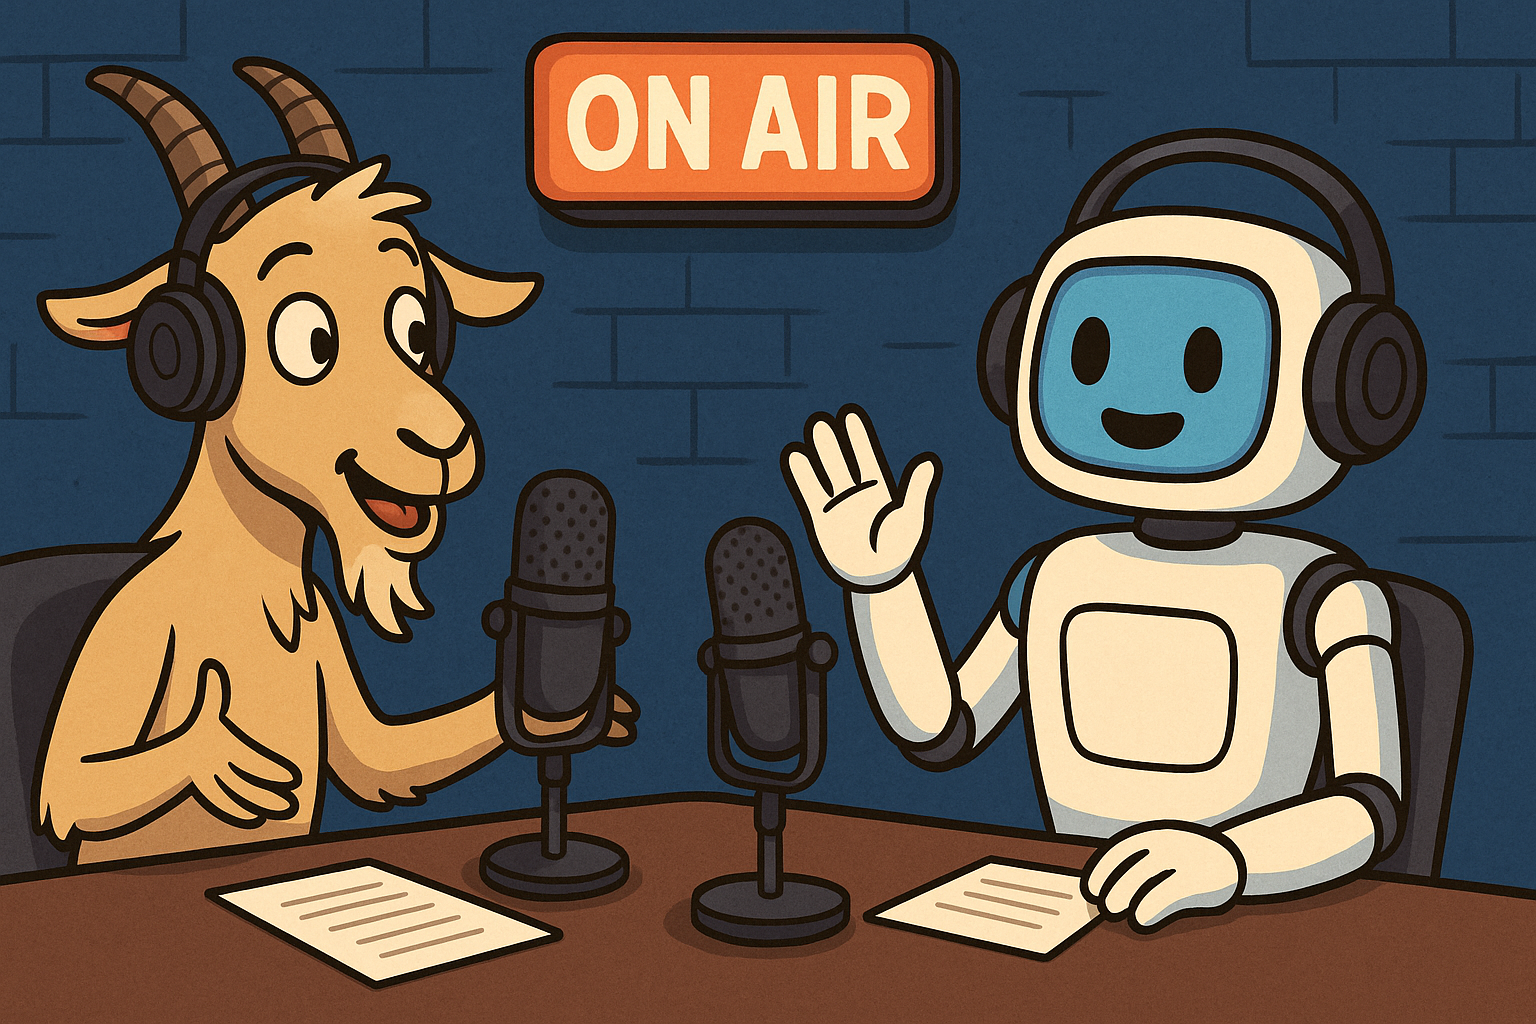

# **How To Use This Notebook:**

It is structured as follows...

1.   First an example of generating a basic short clip with Dia-1.6B using the default randomized voices functionality.

2.   After that, the notebook allows you choose and load base voices which will allow you to create longer podcast style audio files ENSURING CONSISTENT voices throughout.

Beyond this, the notebook also includes:

*   A Dia formatted podcast script generator from any text source you copy paste in. This makes it super simple to quickly create a script which is optimized for how Dia works giving the best possible output. You also of course have the option to modify the script as you wish.

*   The script generator allows you to use a variety of OpenAI, Google Gemini or Anthropic models.

*   The notebook also allows you preview sections of the podcast audio you generate, and redraft/ regenerate parts if needed.

*   Finally the notebook exports a complete single file which you can listen to as a full podcast recording.

# **Package Installs**

😀 The installs usually take a couple of minutes.

In [ ]:
# @title
!pip install -q git+https://github.com/nari-labs/dia.git
!pip install -q soundfile --quiet
!pip install ffmpeg-python --quiet
!pip install openai --quiet
!pip install openai[voice_helpers] --quiet
!pip install tiktoken --quiet
!pip install -U -q google-genai
!pip install anthropic --quiet

# **Set Your API Keys**

To use this notebook and build your solution you will need...


*   A HuggingFace user account and API Key
*   One of the following: an OpenAI, Anthropic or Google AI Studio user account and API Key (with billing setup)

*   As pictured below add your respective API keys to your Google Secrets (see the key icon on the left panel) inserting your key in the 'value' field and assigning the following name:

*   HuggingFace API key name: HF_TOKEN
*   OpenAI API key name: openai_key
*   Google AI Studio API key name: GOOGLE_API_KEY
*   Anthropic API key name: claude_api

Once done, run the below cell link text granting key access to the notebook access if prompted...



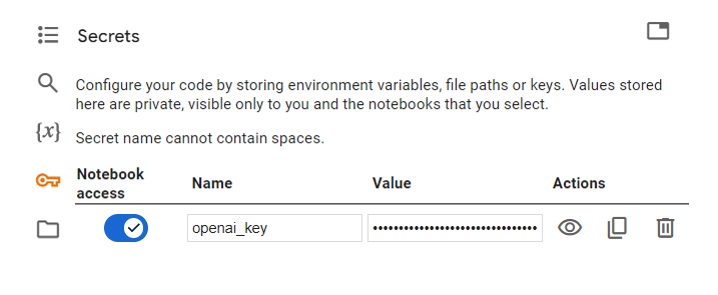

In [ ]:
# @title
#Hugging face api connection setup with Colab

import requests
import os
from anthropic import Anthropic
from google.colab import userdata
from openai import OpenAI
from google import genai
from google.genai import types

#Retrieve the HF API key from Google Colab Secrets
hf_token = userdata.get('HF_TOKEN')

headers = {"Authorization": f"Bearer {hf_token}"}

openai_key = userdata.get("openai_key")
if not openai_key:
    raise ValueError("No OpenAI API key found. Please set openai_key in Colab > 'Table of contents' > 'User snippets'.")

client = OpenAI(api_key=openai_key)
print("✅ OpenAI AI API key set")

# Also set it as an environment variable for later use
import os
os.environ["OPENAI_API_KEY"] = openai_key

# Get API key from Colab secrets
GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')

# Initialize the Google AI client
client = genai.Client(api_key=GOOGLE_API_KEY)

print(f"✅ Google AI API key set")



# Retrieve API keys from Google Colab Secrets
claude_key = userdata.get('claude_api')

os.environ["ANTHROPIC_API_KEY"] = claude_key

# Initialize clients
client = Anthropic(api_key=claude_key)

print("✅ Anthropic AI API key set")

# **Generate a Test Recording (This Might Crash The First Time - Read Below!)**

💀 ***This will probably crash on the first attempt - simply run the cell again IF it does*** 💀

🐢 ***The first loading of the model is really slow, often takes around 5 minutes, but after that it works much faster*** 🐢


*   This code creates a simple soundclip for the following text:

```
[S1] Welcome back to another episode of AI Unfiltered! I’m Jamie.

[S2] And I’m Taylor. Today, we have some really exciting news from the text-to-speech frontier.

[S1] That’s right. There’s a new open source TTS model on the block called Dia.
```

*   Note that S1 and S2 refer to the voices of speaker 1 and speaker 2. These voices are randomly generated each time.

*   Below I will show you how to create consistent voices.

In [ ]:
# @title
# Import libraries
import soundfile as sf
import numpy as np
from dia.model import Dia
import os
import IPython.display as ipd
from google.colab import files
import time
import torch
import gc


def clear_gpu_memory():
    """Clear GPU memory cache"""
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        gc.collect()

def generate_and_play(text, output_filename="output.wav", max_retries=3):
    # Check if text is provided
    if not text or not text.strip():
        print("Error: No text provided for generation.")
        return None

    # Check if model exists, if not, load it with retries
    global model
    retry_count = 0

    while retry_count < max_retries:
        try:
            if 'model' not in globals() or model is None:
                print(f"Model not found. Loading model... (Attempt {retry_count + 1}/{max_retries})")
                model = Dia.from_pretrained("nari-labs/Dia-1.6B")
                print("Model loaded successfully!")
            break
        except Exception as e:
            retry_count += 1
            print(f"Error loading model (Attempt {retry_count}/{max_retries}): {e}")
            if retry_count < max_retries:
                print("Retrying in 5 seconds...")
                time.sleep(5)
            else:
                print("Failed to load model after all retries.")
                return None

    print(f"Generating audio for: \n{text}\n")

    # Clear GPU memory before generation
    clear_gpu_memory()

    # Try generation with different settings if CUDA memory error occurs
    generation_attempts = [
        {"use_torch_compile": True, "verbose": True},
        {"use_torch_compile": False, "verbose": True},
        {"use_torch_compile": False, "verbose": False}
    ]

    for attempt_num, gen_params in enumerate(generation_attempts, 1):
        try:
            print(f"Generation attempt {attempt_num}/3 with params: {gen_params}")
            start_time = time.time()

            # Generate audio
            output = model.generate(text, **gen_params)

            # Check if output is valid
            if output is None or len(output) == 0:
                print("Error: Generated audio output is empty.")
                continue

            # Calculate generation time
            generation_time = time.time() - start_time
            audio_duration = len(output) / 44100  # Assuming 44.1kHz sample rate
            speed_ratio = audio_duration / generation_time

            print(f"Generation took {generation_time:.2f} seconds for {audio_duration:.2f} seconds of audio")
            print(f"Speed ratio: {speed_ratio:.2f}x real-time")

            # Save the audio file
            sf.write(output_filename, output, 44100)

            # Display audio player in Colab
            print("Playing audio...")
            return ipd.Audio(output_filename, autoplay=True)

        except RuntimeError as e:
            if "out of memory" in str(e).lower() or "cuda" in str(e).lower():
                print(f"CUDA memory error on attempt {attempt_num}: {e}")
                clear_gpu_memory()
                if attempt_num < len(generation_attempts):
                    print("Clearing GPU memory and trying with different settings...")
                    time.sleep(2)
                else:
                    print("All generation attempts failed due to memory issues.")
                    print("Try restarting the runtime or using a shorter text.")
                    return None
            else:
                print(f"Error during audio generation (attempt {attempt_num}): {e}")
                if attempt_num < len(generation_attempts):
                    continue
                else:
                    return None
        except Exception as e:
            print(f"Unexpected error during audio generation (attempt {attempt_num}): {e}")
            if attempt_num < len(generation_attempts):
                continue
            else:
                return None

    return None

def load_model_with_retry(max_retries=3):
    """Load the model with retry logic"""
    global model
    retry_count = 0

    while retry_count < max_retries:
        try:
            print(f"Loading Dia model... This may take a few minutes. (Attempt {retry_count + 1}/{max_retries})")
            model = Dia.from_pretrained("nari-labs/Dia-1.6B")
            print("Model loaded successfully!")
            return True
        except Exception as e:
            retry_count += 1
            print(f"Error loading model (Attempt {retry_count}/{max_retries}): {e}")
            if retry_count < max_retries:
                print("Retrying in 10 seconds...")
                time.sleep(10)
            else:
                print("Failed to load model after all retries.")
                return False

# Only run this example if this is the first time loading the code
if 'model' not in globals():
    # Example text - change this to whatever you want
    example_text = """[S1] Welcome back to another episode of AI Unfiltered! I’m Jamie.
[S2] And I’m Taylor. Today, we have some really exciting news from the text-to-speech frontier.
[S1] That’s right. There’s a new open source TTS model on the block called Dia."""


    # Load the model with retry logic
    if load_model_with_retry():
        # Test the function with the example text
        generate_and_play(example_text)
    else:
        print("Could not load model. Please check your internet connection and try again.")
else:
    print("Code already loaded. Model is ready to use.")
    print("Call generate_and_play(your_text) to generate audio.")

# Additional helper function to split long text if memory issues persist
def split_text_and_generate(text, max_chars=500, output_prefix="output_part"):
    """Split long text into smaller chunks and generate audio for each"""
    if len(text) <= max_chars:
        return generate_and_play(text)

    # Split text by sentences or dialogue markers
    parts = []
    lines = text.split('\n')
    current_part = ""

    for line in lines:
        if len(current_part + line + '\n') > max_chars and current_part:
            parts.append(current_part.strip())
            current_part = line + '\n'
        else:
            current_part += line + '\n'

    if current_part.strip():
        parts.append(current_part.strip())

    print(f"Splitting text into {len(parts)} parts due to length.")
    audio_files = []

    for i, part in enumerate(parts):
        filename = f"{output_prefix}_{i+1}.wav"
        print(f"\n--- Generating part {i+1}/{len(parts)} ---")
        result = generate_and_play(part, filename)
        if result:
            audio_files.append(filename)

    return audio_files

def play_audio(filename="output.wav"):
    """
    Play an audio file (supports WAV and MP3)

    Parameters:
    filename (str): Path to the audio file to play
    """
    if not os.path.exists(filename):
        print(f"Error: File '{filename}' not found")
        return

    file_extension = filename.split('.')[-1].lower()
    if file_extension not in ['wav', 'mp3']:
        print(f"Warning: File extension '{file_extension}' might not be supported")

    print(f"Playing {filename}...")
    return ipd.Audio(filename, autoplay=True)

# Example usage:
play_audio("output.wav")  # Change to your filename if needed

# **Now Generate A Recording For a Different Text**

* Now let's try the model again, but on a different text.
* Feel free to modify the text within the quotation marks, but always keep to the S1 / S2 format.

In [ ]:
example_text = """[S1] Hey everyone, welcome back to the show, I'm Jamie.
[S2] And I'm Cody, great to be with you today.
[S1] We've got a fascinating new material discovery.
[S2] Oh really?
[S1] It's big.
[S2] What is it?
[S1] Penn Engineers found something to pull water from thin air.
[S2] From thin air?, """

generate_and_play(example_text)

# **How To Use Dia To Create Longer Outputs with Consistent Voices**

*   As you may have noticed, Dia uses new voices for each audio generation, making  unpredictable

*   However consistency can be achieved by using its voice cloning capability.

*   To help you experiment with this I have created some basic voices that you can use for cloned / consistent output - I saved these in a github repo, so you can simply download them and use them in this notebook.

*   These voices were in fact originally generated by Dia, so there should be no rights / IP issues.

*   The files from the repo include the voice clips AND txt file transcriptions of what the voices say, which the model uses to replicate the voices.

# **Download Example Voices for Cloning**

There are 3 types of voices from the repo, these include:

1.   Two female sounding voices 'f_f_voices.mp3'
2.   A male and female sounding voice 'm_f_voices.mp3'
1.   Two male sounding voices 'm_m_voices.mp3'





In [ ]:
# @title
import os
import subprocess
import json
import re

# Create destination folder
os.makedirs('/content/clone', exist_ok=True)

# GitHub repository details
repo_owner = "smartaces"
repo_name = "dia_podcast_generator"
branch = "main"

# Use GitHub API to get file listing
print(f"Fetching file list from {repo_owner}/{repo_name}...")
api_url = f"https://api.github.com/repos/{repo_owner}/{repo_name}/git/trees/{branch}?recursive=1"

# Use curl to get the file list (already available in Colab)
result = subprocess.run(
    ['curl', '-s', api_url],
    capture_output=True,
    text=True
)

try:
    # Parse the JSON response
    file_data = json.loads(result.stdout)

    # Filter for MP3 files and sample_text files
    filtered_files = []
    for item in file_data.get('tree', []):
        if item['type'] == 'blob':  # It's a file, not a directory
            path = item['path']
            if path.endswith('.mp3') or 'voices.txt' in path:
                filtered_files.append(path)

    if not filtered_files:
        print("No matching files found in the repository.")
    else:
        print(f"Found {len(filtered_files)} files to download.")

        # Download each file
        for file_path in filtered_files:
            filename = os.path.basename(file_path)
            download_url = f"https://raw.githubusercontent.com/{repo_owner}/{repo_name}/{branch}/{file_path}"

            print(f"Downloading {filename}...")
            subprocess.run(
                ['wget', '-q', download_url, '-O', f'/content/clone/{filename}'],
                check=True
            )

        print("\nDownloaded files:")
        for file_path in filtered_files:
            print(f"- {os.path.basename(file_path)}")

        print(f"\nAll files saved to /content/clone/")
        subprocess.run(['ls', '-la', '/content/clone/'])

except json.JSONDecodeError:
    print("Error parsing repository data. Using alternate method...")

    # Alternative method: Clone repository temporarily and copy files
    temp_dir = "/tmp/dia_repo"
    subprocess.run(['rm', '-rf', temp_dir], check=True)
    subprocess.run(['mkdir', '-p', temp_dir], check=True)

    # Clone repository
    clone_cmd = f"git clone https://github.com/{repo_owner}/{repo_name}.git {temp_dir}"
    subprocess.run(clone_cmd, shell=True, check=True)

    # Find and copy MP3 and sample_text.txt files
    find_cmd = f"find {temp_dir} -name '*.mp3' -o -name '*voices.txt*'"
    files = subprocess.run(find_cmd, shell=True, capture_output=True, text=True).stdout.strip().split('\n')

    for file_path in files:
        if file_path:  # Skip empty lines
            filename = os.path.basename(file_path)
            copy_cmd = f"cp '{file_path}' '/content/clone/{filename}'"
            subprocess.run(copy_cmd, shell=True, check=True)
            print(f"Copied {filename}")

    # Clean up
    subprocess.run(['rm', '-rf', temp_dir], check=True)

    print(f"\nAll files saved to /content/clone/")
    subprocess.run(['ls', '-la', '/content/clone/'])

# **Add Your Own Cloned Voices (With Transcripts)**

You can also add your own voices by  adding an mp3 clip, and the respective text transcription of the recording to this project via the below upload tool:

*   Use a 10 to 15 second audio clip for best results.
*   You can see examples of these files in the clone folder of this notebook.
*   Be sure to use this [S1]/ [S2] format structure for the text transcription file:


```
[S1] Welcome back to another episode of AI Unfiltered! I'm Jamie.

[S2] And I'm Taylor. Today, we have some really exciting news from the text-to-speech frontier.

[S1] That's right! There's a new open source TTS model on the block called Dia.

[S2] So, Dia is developed by a two-person startup called Nari Labs.
```

*   Note that when using the below tool the .txt transcription file will be renamed to match the name of the mp3 you uploaded, this is necessary for the podcast generator to work.

In [ ]:
# @title
import ipywidgets as widgets
from IPython.display import display, clear_output
import IPython.display as ipd
import os
import json
import re
from datetime import datetime

def natural_sort_key(s):
    """Sort strings with numbers in natural order"""
    return [int(text) if text.isdigit() else text.lower() for text in re.split(r'(\d+)', s)]

def get_clone_audio_files():
    """Get a sorted list of audio files from the /content/clone directory"""
    import glob
    mp3_files = glob.glob("/content/clone/*.mp3")
    wav_files = glob.glob("/content/clone/*.wav")
    files = mp3_files + wav_files
    return sorted(files, key=natural_sort_key)

def load_text_content(file_path):
    """Load text content from file"""
    if not file_path or not os.path.exists(file_path):
        return ""

    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            content = f.read().strip()
            # Remove triple quotes if they exist
            if content.startswith('"""') and content.endswith('"""'):
                content = content[3:-3].strip()
            return content
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")
        return ""

def save_text_content(file_path, content):
    """Save text content to file"""
    try:
        # Create directory if it doesn't exist
        os.makedirs(os.path.dirname(file_path), exist_ok=True)

        with open(file_path, 'w', encoding='utf-8') as f:
            # Save with triple quotes for consistency with your existing format
            f.write(f'"""{content}"""')
        return True
    except Exception as e:
        print(f"Error saving file {file_path}: {e}")
        return False

def create_audio_upload_editor():
    """Create the audio upload and editor interface"""

    # Create destination folder
    os.makedirs('/content/clone', exist_ok=True)

    # Audio file upload widget
    audio_upload = widgets.FileUpload(
        accept='.mp3,.wav,.m4a,.ogg',  # Accept common audio formats
        multiple=False,
        description='Upload Audio:',
        style={'description_width': 'initial'},
        layout={'width': '400px'}
    )

    # Text file upload widget
    text_upload = widgets.FileUpload(
        accept='.txt',  # Accept text files
        multiple=False,
        description='Upload Transcript:',
        style={'description_width': 'initial'},
        layout={'width': '400px'}
    )

    # Existing files dropdown
    existing_files = get_clone_audio_files()
    existing_options = ['Select existing file...'] + [os.path.basename(f) for f in existing_files]

    existing_dropdown = widgets.Dropdown(
        options=existing_options,
        value='Select existing file...',
        description='Or Select Existing:',
        style={'description_width': 'initial'},
        layout={'width': '400px'}
    )

    # Audio player area
    audio_player_area = widgets.Output()

    # File info display
    file_info = widgets.HTML(value="<small>Upload an audio file or select an existing one</small>")

    # Text editor
    text_editor = widgets.Textarea(
        value='',
        placeholder='Upload or select an audio file to edit its transcript...',
        description='Edit Transcript:',
        style={'description_width': 'initial'},
        layout={'width': '800px', 'height': '300px'}
    )

    # Buttons
    refresh_btn = widgets.Button(
        description='Refresh Files',
        button_style='info',
        icon='refresh',
        tooltip='Refresh the list of existing audio files'
    )

    save_text_btn = widgets.Button(
        description='Save Transcript',
        button_style='warning',
        icon='save',
        tooltip='Save the transcript to a text file'
    )

    delete_btn = widgets.Button(
        description='Delete Selected File',
        button_style='danger',
        icon='trash',
        tooltip='Delete the currently selected audio and text files'
    )

    # Output area for messages
    output_area = widgets.Output()

    # Store current file paths
    current_audio_path = None
    current_text_path = None

    def display_audio_and_text(audio_path):
        """Display audio player and load corresponding text"""
        nonlocal current_audio_path, current_text_path

        current_audio_path = audio_path
        audio_basename = os.path.splitext(audio_path)[0]
        current_text_path = f"{audio_basename}.txt"

        # Display audio player
        with audio_player_area:
            clear_output()
            print(f"🎵 Playing: {os.path.basename(audio_path)}")
            display(ipd.Audio(audio_path, autoplay=False))

        # Load corresponding text file
        text_content = load_text_content(current_text_path)
        text_editor.value = text_content

        # Update file info
        text_exists = os.path.exists(current_text_path)
        file_info.value = f"""
        <small>
        <b>Audio:</b> {os.path.basename(audio_path)}<br>
        <b>Text File:</b> {os.path.basename(current_text_path)} {'✅' if text_exists else '❌ (will be created when saved)'}
        </small>
        """

    def on_audio_upload(change):
        """Handle audio file upload"""
        with output_area:
            clear_output()

        if not audio_upload.value:
            return

        try:
            # Get the uploaded file
            uploaded_file = list(audio_upload.value.values())[0]
            filename = uploaded_file['metadata']['name']
            content = uploaded_file['content']

            # Save to /content/clone directory
            file_path = f"/content/clone/{filename}"

            with open(file_path, 'wb') as f:
                f.write(content)

            with output_area:
                print(f"✅ Uploaded audio: {filename}")
                print(f"📁 Saved to: {file_path}")

            # Display the uploaded audio
            display_audio_and_text(file_path)

            # Refresh the existing files dropdown
            refresh_existing_files()

        except Exception as e:
            with output_area:
                print(f"❌ Error uploading audio file: {str(e)}")

    def on_text_upload(change):
        """Handle transcript file upload"""
        with output_area:
            clear_output()

        if not text_upload.value:
            return

        try:
            # Get the uploaded file
            uploaded_file = list(text_upload.value.values())[0]
            original_filename = uploaded_file['metadata']['name']
            content = uploaded_file['content']

            # Decode the content
            text_content = content.decode('utf-8').strip()
            # Remove existing triple quotes if present to avoid double-wrapping
            if text_content.startswith('"""') and text_content.endswith('"""'):
                text_content = text_content[3:-3].strip()

            # Determine the target filename
            if current_audio_path:
                # If we have a current audio file, rename transcript to match
                audio_basename = os.path.splitext(current_audio_path)[0]
                target_filename = f"{os.path.basename(audio_basename)}.txt"
                file_path = f"{audio_basename}.txt"

                with output_area:
                    print(f"✅ Uploaded transcript: {original_filename}")
                    if original_filename != target_filename:
                        print(f"🔄 Renamed to match audio file: {target_filename}")
                    print(f"📁 Saved to: {file_path}")
            else:
                # No current audio file, save with original name
                file_path = f"/content/clone/{original_filename}"
                with output_area:
                    print(f"✅ Uploaded transcript: {original_filename}")
                    print(f"📁 Saved to: {file_path}")
                    print(f"💡 Select an audio file to automatically pair transcripts")

            # Save the text file
            with open(file_path, 'w', encoding='utf-8') as f:
                f.write(f'"""{text_content}"""')

            # If we have a current audio file, reload the interface
            if current_audio_path:
                # Reload the text editor with the uploaded content
                text_editor.value = text_content
                print(f"📝 Loaded transcript for current audio file")

                # Update file info
                file_info.value = f"""
                <small>
                <b>Audio:</b> {os.path.basename(current_audio_path)}<br>
                <b>Text File:</b> {os.path.basename(file_path)} ✅
                </small>
                """

                # Update the current text path
                nonlocal current_text_path
                current_text_path = file_path

        except Exception as e:
            with output_area:
                print(f"❌ Error uploading transcript file: {str(e)}")

    def on_existing_selection_change(change):
        """Handle existing file selection"""
        with output_area:
            clear_output()

        if change.new == 'Select existing file...':
            nonlocal current_audio_path, current_text_path
            current_audio_path = None
            current_text_path = None
            text_editor.value = ''
            file_info.value = "<small>Upload an audio file or select an existing one</small>"
            with audio_player_area:
                clear_output()
            return

        # Find the full path of selected audio file
        existing_files = get_clone_audio_files()
        selected_audio = None
        for audio_file in existing_files:
            if os.path.basename(audio_file) == change.new:
                selected_audio = audio_file
                break

        if selected_audio:
            with output_area:
                print(f"📂 Selected existing file: {os.path.basename(selected_audio)}")
            display_audio_and_text(selected_audio)

    def refresh_existing_files():
        """Refresh the dropdown with existing files"""
        existing_files = get_clone_audio_files()
        existing_options = ['Select existing file...'] + [os.path.basename(f) for f in existing_files]
        existing_dropdown.options = existing_options

    def on_refresh_click(b):
        """Handle refresh button click"""
        with output_area:
            clear_output()
            print("🔄 Refreshing file list...")

        refresh_existing_files()

        with output_area:
            existing_files = get_clone_audio_files()
            print(f"✅ Found {len(existing_files)} audio files in /content/clone/")

    def on_save_text_click(b):
        """Handle save text button click"""
        with output_area:
            clear_output()

        if not current_audio_path:
            with output_area:
                print("❌ No audio file selected!")
            return

        if not text_editor.value.strip():
            with output_area:
                print("❌ Transcript is empty!")
            return

        # Save the text
        if save_text_content(current_text_path, text_editor.value):
            with output_area:
                print(f"✅ Transcript saved to: {os.path.basename(current_text_path)}")

            # Update file info to show text file now exists
            file_info.value = f"""
            <small>
            <b>Audio:</b> {os.path.basename(current_audio_path)}<br>
            <b>Text File:</b> {os.path.basename(current_text_path)} ✅
            </small>
            """
        else:
            with output_area:
                print("❌ Failed to save transcript!")

    def on_delete_click(b):
        """Handle delete button click"""
        with output_area:
            clear_output()

        if not current_audio_path:
            with output_area:
                print("❌ No file selected for deletion!")
            return

        try:
            # Delete audio file
            if os.path.exists(current_audio_path):
                os.remove(current_audio_path)
                print(f"🗑️ Deleted audio: {os.path.basename(current_audio_path)}")

            # Delete text file if it exists
            if current_text_path and os.path.exists(current_text_path):
                os.remove(current_text_path)
                print(f"🗑️ Deleted text: {os.path.basename(current_text_path)}")

            # Clear the interface
            text_editor.value = ''
            file_info.value = "<small>Upload an audio file or select an existing one</small>"
            with audio_player_area:
                clear_output()

            # Reset selections
            existing_dropdown.value = 'Select existing file...'

            # Refresh file list
            refresh_existing_files()

            print("✅ Files deleted successfully!")

        except Exception as e:
            print(f"❌ Error deleting files: {str(e)}")

    # Connect event handlers
    audio_upload.observe(on_audio_upload, names='value')
    text_upload.observe(on_text_upload, names='value')
    existing_dropdown.observe(on_existing_selection_change, names='value')
    refresh_btn.on_click(on_refresh_click)
    save_text_btn.on_click(on_save_text_click)
    delete_btn.on_click(on_delete_click)

    # Layout the interface
    header = widgets.HTML("<h3>🎤 Audio File Upload & Transcript Editor</h3>")
    description = widgets.HTML(
        "<p>Upload audio files and their corresponding transcript files from your computer, or select existing ones from /content/clone/. "
        "Edit transcripts and save them as text files with the same name as the audio file.</p>"
    )

    upload_section = widgets.VBox([
        widgets.HTML("<h4>📁 File Management</h4>"),
        widgets.HBox([audio_upload, text_upload, refresh_btn]),
        existing_dropdown,
        widgets.HTML("<small><i>💡 Tip: Select an audio file first, then upload a transcript - it will be automatically renamed to match the audio file</i></small>")
    ])

    editor_section = widgets.VBox([
        widgets.HTML("<h4>🎵 Audio Player & Transcript Editor</h4>"),
        file_info,
        audio_player_area,
        text_editor,
        widgets.HBox([save_text_btn, delete_btn])
    ])

    interface = widgets.VBox([
        header,
        description,
        upload_section,
        editor_section,
        output_area
    ], layout=widgets.Layout(spacing='15px'))

    # Initial refresh
    refresh_existing_files()

    display(interface)

# Run the editor
print("🚀 Initializing Audio Upload & Transcript Editor...")
create_audio_upload_editor()

# **Dia Format Podcast Text Script Creator**

As you may have notice Dia requires scripts to be in a certain format.

Dia also works best with short interactions between the speakers.

At a maximum it can output 20-30 seconds of audio, but if you try to generate too many words, the resulting output is sped up.

**To help create a text for your Dia generations, I created a script generator powered by Anthropic Sonnet 4, Google Gemini Flash 2.5, or GPT4o.**

*   The tool below allows you to paste in some raw text, for example a blog article, and then generate a speaker script for two Dia voices.

*   To control the length of the script you can select different approximate recording times in minutes.

*   **For best results in script quality use Anthropic Sonnet 4 or Gemini Flash.**

*   Remember you will need an OpenAI, Google AI Studio or Anthropic API key to use this tool. Add either or all of your keys to the secrets tab of this notebook and  name them as

*   **openai_key** for your OpenAI key
*   **GOOGLE_API_KEY** for your Google AI Studio API Key
*   **claude_api** for your Anthropic API Key

*   Once you have generated a script and like it, click split the Script into Files so that it can be loaded and run through the DIA model in the following steps.

*   The script uses specific formatting of 'segments' so that it will be processed correctly, ensure that you replicate this layout for each segment including the asterisks:

**Segment Example**


```
[S1] Hey everyone, welcome back to the show, I'm Jamie.
[S2] And I'm Cody, ready for some AI algorithm talk?
[S1] Absolutely, today we're diving into AlphaEvolve.
[S2] AlphaEvolve, interesting, what is it?
[S1] It's a new AI agent from Google.
[S2] I see.
[S1] Evolving algorithms for math and practical computing.
[S2] Sounds ambitious, tell me more.
***************
```

In [ ]:
# @title
import os
import time
import ipywidgets as widgets
from IPython.display import display, clear_output
from datetime import datetime

# Import libraries
from openai import OpenAI
from google.colab import userdata
from google import genai
from anthropic import Anthropic
import threading

# Initialize API clients
def initialize_clients():
    """Initialize OpenAI, Google AI, and Anthropic clients"""
    clients = {}

    # OpenAI setup
    try:
        openai_key = userdata.get("openai_key")
        if openai_key:
            clients['openai'] = OpenAI(api_key=openai_key)
            os.environ["OPENAI_API_KEY"] = openai_key
            print("✓ OpenAI client initialized")
        else:
            print("⚠ No OpenAI API key found")
    except Exception as e:
        print(f"⚠ OpenAI initialization failed: {e}")

    # Google AI setup
    try:
        google_key = userdata.get("GOOGLE_API_KEY")
        if google_key:
            clients['google'] = genai.Client(api_key=google_key)
            print("✓ Google AI client initialized")
        else:
            print("⚠ No Google API key found")
    except Exception as e:
        print(f"⚠ Google AI initialization failed: {e}")

    # Anthropic Claude setup
    try:
        claude_key = userdata.get("claude_api")
        if claude_key:
            clients['claude'] = Anthropic(api_key=claude_key)
            os.environ["ANTHROPIC_API_KEY"] = claude_key
            print("✓ Anthropic Claude client initialized")
        else:
            print("⚠ No Anthropic API key found")
    except Exception as e:
        print(f"⚠ Anthropic initialization failed: {e}")

    return clients

# Initialize clients
clients = initialize_clients()

# Create necessary folders
os.makedirs('dia_scripts', exist_ok=True)
os.makedirs('/content/texts', exist_ok=True)

# Add these global variables after your existing variables
animation_running = False
animation_thread = None

# Add these new functions anywhere before your UI components
def animate_loading_emojis(output_widget, base_message):
    """Animate rotating emojis while generation is running"""
    global animation_running
    emojis = ["✏️", "⚙️", "😊"]  # pencil, cog, smiley face
    emoji_index = 0

    while animation_running:
        with output_widget:
            clear_output(wait=True)
            current_emoji = emojis[emoji_index % len(emojis)]
            print(f"{base_message} {current_emoji}")

        emoji_index += 1
        time.sleep(0.5)  # Rotate every 0.5 seconds

def start_loading_animation(output_widget, message):
    """Start the loading animation"""
    global animation_running, animation_thread
    animation_running = True
    animation_thread = threading.Thread(target=animate_loading_emojis, args=(output_widget, message))
    animation_thread.daemon = True
    animation_thread.start()

def stop_loading_animation():
    """Stop the loading animation"""
    global animation_running
    animation_running = False
    if animation_thread:
        animation_thread.join(timeout=1)

def generate_dia_script_openai(content, client, num_segments):
    """Generate a podcast script using OpenAI GPT-4o model"""
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {
                "role": "user",
                "content": f"""Create a podcast dialogue between two speakers discussing this content:

{content}

Format requirements:
- Use [S1] to indicate Speaker 1 and [S2] to indicate Speaker 2
- CRITICAL: Each segment must have exactly 8 lines alternating between speakers: S1, S2, S1, S2, S1, S2, S1, S2
- After each segment (eight lines total - S1, S2, S1, S2, S1, S2, S1, S2), add a line with exactly 15 asterisks: ***************
- NEVER include any voice descriptions or sound effects like (laughs), (sighs), etc.
- The hosts are called Jamie and Cody
- Each speaker gets exactly four lines EACH per segment
- Each speaker may only speak 9 words per line maximum
- Per segment each speaker must have at least one line of less than FOUR WORDS.
- The podcast must be MORE THAN {num_segments} segments long MINIMUM
- EVERY line MUST end with a period ".", question mark "?" or comma ","
- Carefully analyse the approach in the Example format
- Perfectly simulate and replicate the award winning style of NATURAL SOUNDING HUMAN dialogue
- ENSURE THAT the following are used

Conversational Flow Techniques:
1. Natural Interruption Patterns

S2 interrupts with "I see" - mimics how people naturally seek clarification
Creates authentic back-and-forth rhythm rather than scripted monologues

2. Progressive Information Revelation

Information is parceled out in digestible chunks
Each exchange builds on the previous one without overwhelming the listener

3. Authentic Interjections

"Yeah", "Wow", "right?" - these are genuine conversational fillers people actually use
They buy thinking time and show active listening

Engagement Strategies:
4. Question-Response Dynamics

S2's "Opus 4?" shows genuine curiosity and pulls the listener in
Questions create natural momentum and anticipation

5. Emotional Reactions

"Wow, that is so cool" - genuine enthusiasm makes content more engaging
"quite a big claim right?" - adds skepticism that mirrors listener thoughts

6. Inclusive Language

"guess what" - creates anticipation and includes the listener in the revelation
Conversational phrases that make listeners feel part of the discussion

Structural Elements:
7. Segmented Information Architecture

Each speaker gets 4 lines maximum before switching
Prevents information overload and maintains attention

8. Natural Topic Transitions

"So, starting with..." - clear but conversational signposting
Smooth flow from general introduction to specific details

9. Active Listening Cues

Responses show speakers are genuinely processing information
"That is so cool" shows S2 is engaged, not just waiting for their turn

10. EVERY line MUST end with a period ".", question mark "?" or comma ","

MIMIC THE FOLLOWING EXAMPLE FORMAT DIALOGUE STRUCTURES CLOSELY!

Example format:

[S1] Hey everyone, welcome back to the show, I'm Jamie.
[S2] And I'm Cody, great to be with you Jamie.
[S1] Likewise, we've got a great discussion topic for today.
[S2] Yeah, the next generation of Claude models Sonnet and Opus 4.
[S1] So, starting with Opus 4.
[S2] Opus 4?
[S1] Yeah, it's here, and guess what, it's being called the world's best coding model.
[S2] Wow, that is so cool and quite a big claim right?
***************
[S1] Yep, and according to the benchmarks it is great for long coding tasks.
[S2] I can imagine that is huge for big projects.
[S1] Totally, I have a few I need to finish.
[S2] Me too, so many projects.
[S1] I heard it's not just about coding though.
[S2] Oh really?
[S1] There's advanced reasoning too, plus agent workflows.
[S2] Agent workflows sound interesting, what do those do?
***************
[S1] They help automate processes.
[S2] Nice.
[S1] Right, agents that don't drop the ball halfway is such a plus.
[S2] Wow Opus sounds like a big upgrade.
[S1] On the Sonnet side.
[S2] Yeah?
[S1] Sonnet 4 is replacing Sonnet 3.7.
[S2] What are the big differences between those two?
***************
[S1] Sonnet 4 has more precise coding.
[S2] Cool.
[S1] And is better at following instructions.
[S2] Nice, re-explaining prompts can be such a pain.
[S1] Beyond the models, what else is new?
[S2] So, Anthropic have also launched extended thinking.
[S1] Oh cool.
[S2] Yep, with tool use too.
***************
[S1] What does that mean exactly?
[S2] AI that can alternate between thinking and using real tools.
[S1] That sounds powerful.
[S2] Yeah, it's like having a real assistant.
[S1] And there's new memory features.
[S2] Memory features?
[S1] Especially if you give it file access.
[S2] So Claude could actually keep track of what it's doing?
***************
[S1] Exactly, across tasks.
[S2] Nice.
[S1] I can see how useful that is for long projects.
[S2] For sure, it means less starting over every time.
[S1] On the API front.
[S2] Oh yeah?
[S1] They're adding four new capabilities.
[S2] Four new ones, what are they?
***************
[S1] Code execution tool, MCP connector.
[S2] Okay.
[S1] A Files API, and caching prompts.
[S2] Caching prompts is a huge time and cost saver.
[S1] The code execution tool is interesting.
[S2] How so?
[S1] It means Claude can actually run code directly.
[S2] That's pretty revolutionary for debugging.
***************
[S1] And the MCP connector.
[S2] MCP?
[S1] Model Context Protocol, it connects to external systems.
[S2] So it can interact with other apps?
[S1] Exactly, like databases, APIs, all sorts of tools.
[S2] That opens up so many possibilities.
[S1] The Files API is neat too.
[S2] What does that one do?
***************
[S1] It lets you upload and manage files properly.
[S2] Finally.
[S1] No more copy-pasting huge documents.
[S2] Thank goodness, that was getting old.
[S1] The pricing is interesting too.
[S2] How so?
[S1] Opus 4 is more expensive but way more capable.
[S2] Makes sense for the performance boost.
***************
[S1] Sonnet 4 stays affordable.
[S2] Good.
[S1] So you can choose based on your needs.
[S2] That's smart, gives everyone options.
[S1] What do you think the biggest impact will be?
[S2] Probably the agent workflows.
[S1] Yeah?
[S2] Being able to automate complex tasks end-to-end.
***************
[S1] I'm excited about the memory features.
[S2] Those are cool.
[S1] No more explaining the same context over and over.
[S2] That'll save so much time.
[S1] The coding improvements are huge too.
[S2] Definitely.
[S1] Especially for those long, complex projects.
[S2] Yeah, where you need consistency throughout.
***************
[S1] Any concerns about these new models?
[S2] Maybe the cost?
[S1] Opus 4 is pricier.
[S2] But if it saves time, it might be worth it.
[S1] The capabilities are pretty impressive.
[S2] They really are.
[S1] It feels like we're getting closer to truly helpful AI.
[S2] Agreed, these aren't just incremental updates.
***************
[S1] So what should people try first?
[S2] I'd say start with Sonnet 4.
[S1] Good entry point?
[S2] Yeah, familiar but better.
[S1] Then experiment with Opus 4 for bigger projects?
[S2] Exactly.
[S1] And definitely try the new API features.
[S2] Those are game-changers.
***************
[S1] Well, that's a wrap on today's discussion.
[S2] Thanks for tuning in everyone.
[S1] We'll be back next week with more AI updates.
[S2] Until then, keep experimenting.
***************

Example 2:

[S1] Hey everyone, welcome back to the show, I'm Jamie.
[S2] And I'm Cody, great to be with you today.
[S1] We've got some massive tech news to discuss.
[S2] Yeah?
[S1] So Jony Ive is joining OpenAI.
[S2] Wait, the Apple designer?
[S1] Yep, that's the one, the guy behind the iPhone.
[S2] Wow
***************
[S1] Sam Altman is calling him the greatest designer ever.
[S2] That's quite the endorsement.
[S1] I mean, he's not wrong though.
[S2] True.
[S1] The man designed the iPod, iPhone, iPad.
[S2] All iconic products.
[S1] OpenAI bought his startup for six and a half billion.
[S2] That's serious money
***************
[S1] Altman says they want to reimagine what computers are.
[S2] That sounds pretty ambitious.
[S1] I think it makes sense though.
[S2] How so?
[S1] Well, AI software has advanced so much recently.
[S2] Right.
[S1] But the hardware side has been lagging behind.
[S2] Yeah, I've noticed that gap too
***************
[S1] Remember those AI devices that came out recently?
[S2] Oh yeah?
[S1] Like the Humane AI Pin thing.
[S2] That was a disaster.
[S1] Battery problems, overheating, limited functionality.
[S2] Ouch.
[S1] I think reviewers absolutely destroyed it.
[S2] So OpenAI wants to avoid that mistake
***************
[S1] Jony says we're on the brink of something new.
[S2] What kind of new?
[S1] He's talking about a whole family of devices.
[S2] Interesting.
[S1] And apparently they've already got a prototype.
[S2] Really?
[S1] Altman says it's the coolest tech he's ever seen.
[S2] That's a bold claim
***************
[S1] I'm curious what these devices will actually do.
[S2] Same.
[S1] I mean, what would an AI computer look like?
[S2] Good question.
[S1] Maybe something completely different from current laptops.
[S2] Yeah.
[S1] Or maybe it responds to voice naturally.
[S2] That would be revolutionary
***************
[S1] Jony worked at Apple for twenty seven years.
[S2] That's almost three decades.
[S1] He basically saved the company back then.
[S2] How?
[S1] The iMac really turned things around.
[S2] Right.
[S1] I remember when that came out in ninety eight.
[S2] Those colorful designs were so different
***************
[S1] When he left Apple, Tim Cook was pretty emotional.
[S2] What did he say?
[S1] Called him a singular figure in design.
[S2] High praise.
[S1] I think his role in Apple's revival was massive.
[S2] Definitely.
[S1] Apple shares actually dropped when this news broke.
[S2] How much?
***************
[S1] More than two percent in one day.
[S2] Investors are worried.
[S1] I can understand that concern.
[S2] Yeah.
[S1] But he left Apple back in twenty nineteen.
[S2] Right.
[S1] To start his own company called LoveFrom.
[S2] What have they been working on
***************
[S1] They've done projects with Airbnb and fashion brands.
[S2] Interesting mix.
[S1] But apparently they've been quietly working with OpenAI.
[S2] For how long?
[S1] Two years according to the announcement.
[S2] Wow.
[S1] So this has been in the works.
[S2] That explains the quick acquisition
***************
[S1] The startup is called io, founded just last year.
[S2] Pretty quick.
[S1] I think OpenAI already owned twenty three percent.
[S2] So they were invested.
[S1] Makes the acquisition less surprising then.
[S2] True.
[S1] Ben Wood from CCS Insight had some thoughts.
[S2] What did he say
***************
[S1] He said it would be foolish to bet against Jony.
[S2] Given his track record?
[S1] Exactly, the guy has disrupted markets before.
[S2] Multiple times.
[S1] Wood also thinks OpenAI wants direct customer relationships.
[S2] Instead of going through Apple?
[S1] Yeah, cut out the middleman completely.
[S2] Smart business move
***************
[S1] There's also the credibility factor here.
[S2] How so?
[S1] AI hardware has been getting bad reviews lately.
[S2] People are skeptical.
[S1] But Jony's name carries serious weight.
[S2] His reputation could change things.
[S1] I think it keeps the hype machine going.
[S2] Marketing gold
***************
[S1] Other companies are trying AI hardware too.
[S2] Like who?
[S1] Meta's working on headsets and smart glasses.
[S2] The Ray Ban thing?
[S1] Yeah, and Google's got their own projects.
[S2] Right.
[S1] Apple's obviously in the mix somewhere.
[S2] Competition is heating up
***************
[S1] I think timing is everything here.
[S2] What do you mean?
[S1] ChatGPT launched in twenty twenty two.
[S2] Started the AI boom.
[S1] Now everyone's trying to figure out hardware.
[S2] The software is there.
[S1] But nobody's cracked the hardware side yet.
[S2] Whoever does wins big
***************
[S1] What do you think these devices will look like?
[S2] I honestly have no idea.
[S1] Maybe something we haven't even imagined yet.
[S2] Very Jony Ive.
[S1] He's always thought outside the box.
[S2] Remember smartphones with keyboards?
[S1] And then the iPhone changed everything.
[S2] This could be another moment like that
***************
[S1] I'm excited to see what they come up with.
[S2] Same here.
[S1] The prototype Altman mentioned sounds promising.
[S2] If it's really that good.
[S1] We'll have to wait and see I guess.
[S2] Yeah.
[S1] Thanks for joining us today everyone.
[S2] We'll keep you updated as this develops


The format is extremely critical - ALWAYS exactly eight speaker lines (four S1, four S2) alternating throughout the segment, followed by a line of 15 asterisks. Generate more than {num_segments} segments MINIMUM as requested.
"""
            }
        ]
    )
    return response.choices[0].message.content

def generate_dia_script_claude(content, client, num_segments):
    """Generate a podcast script using Anthropic Claude Sonnet 4 model"""
    response = client.messages.create(
        model="claude-sonnet-4-20250514",
        max_tokens=20000,
        temperature=1,
        messages=[
            {
                "role": "user",
                "content": f"""Create a podcast dialogue between two speakers discussing this content:

{content}

Format requirements:
- Use [S1] to indicate Speaker 1 and [S2] to indicate Speaker 2
- CRITICAL: Each segment must have exactly 8 lines alternating between speakers: S1, S2, S1, S2, S1, S2, S1, S2
- After each segment (eight lines total - S1, S2, S1, S2, S1, S2, S1, S2), add a line with exactly 15 asterisks: ***************
- NEVER include any voice descriptions or sound effects like (laughs), (sighs), etc.
- The hosts are called Jamie and Cody
- Each speaker gets exactly four lines EACH per segment
- Each speaker may only speak 9 words per line maximum
- Per segment each speaker must have at least one line of less than FOUR WORDS.
- The podcast must be MORE THAN {num_segments} segments long MINIMUM
- EVERY line MUST end with a period ".", question mark "?" or comma ","
- Carefully analyse the approach in the Example format
- Perfectly simulate and replicate the award winning style of NATURAL SOUNDING HUMAN dialogue
- ENSURE THAT the following are used

Conversational Flow Techniques:
1. Natural Interruption Patterns

S2 interrupts with "I see" - mimics how people naturally seek clarification
Creates authentic back-and-forth rhythm rather than scripted monologues

2. Progressive Information Revelation

Information is parceled out in digestible chunks
Each exchange builds on the previous one without overwhelming the listener

3. Authentic Interjections

"Yeah", "Wow", "right?" - these are genuine conversational fillers people actually use
They buy thinking time and show active listening

Engagement Strategies:
4. Question-Response Dynamics

S2's "Opus 4?" shows genuine curiosity and pulls the listener in
Questions create natural momentum and anticipation

5. Emotional Reactions

"Wow, that is so cool" - genuine enthusiasm makes content more engaging
"quite a big claim right?" - adds skepticism that mirrors listener thoughts

6. Inclusive Language

"guess what" - creates anticipation and includes the listener in the revelation
Conversational phrases that make listeners feel part of the discussion

Structural Elements:
7. Segmented Information Architecture

Each speaker gets 4 lines maximum before switching
Prevents information overload and maintains attention

8. Natural Topic Transitions

"So, starting with..." - clear but conversational signposting
Smooth flow from general introduction to specific details

9. Active Listening Cues

Responses show speakers are genuinely processing information
"That is so cool" shows S2 is engaged, not just waiting for their turn

10. EVERY line MUST end with a period ".", question mark "?" or comma ","

MIMIC THE FOLLOWING EXAMPLE FORMAT DIALOGUE STRUCTURES CLOSELY!

Example format:

[S1] Hey everyone, welcome back to the show, I'm Jamie.
[S2] And I'm Cody, great to be with you Jamie.
[S1] Likewise, we've got a great discussion topic for today.
[S2] Yeah, the next generation of Claude models Sonnet and Opus 4.
[S1] So, starting with Opus 4.
[S2] Opus 4?
[S1] Yeah, it's here, and guess what, it's being called the world's best coding model.
[S2] Wow, that is so cool and quite a big claim right?
***************
[S1] Yep, and according to the benchmarks it is great for long coding tasks.
[S2] I can imagine that is huge for big projects.
[S1] Totally, I have a few I need to finish.
[S2] Me too, so many projects.
[S1] I heard it's not just about coding though.
[S2] Oh really?
[S1] There's advanced reasoning too, plus agent workflows.
[S2] Agent workflows sound interesting, what do those do?
***************
[S1] They help automate processes.
[S2] Nice.
[S1] Right, agents that don't drop the ball halfway is such a plus.
[S2] Wow Opus sounds like a big upgrade.
[S1] On the Sonnet side.
[S2] Yeah?
[S1] Sonnet 4 is replacing Sonnet 3.7.
[S2] What are the big differences between those two?
***************
[S1] Sonnet 4 has more precise coding.
[S2] Cool.
[S1] And is better at following instructions.
[S2] Nice, re-explaining prompts can be such a pain.
[S1] Beyond the models, what else is new?
[S2] So, Anthropic have also launched extended thinking.
[S1] Oh cool.
[S2] Yep, with tool use too.
***************
[S1] What does that mean exactly?
[S2] AI that can alternate between thinking and using real tools.
[S1] That sounds powerful.
[S2] Yeah, it's like having a real assistant.
[S1] And there's new memory features.
[S2] Memory features?
[S1] Especially if you give it file access.
[S2] So Claude could actually keep track of what it's doing?
***************
[S1] Exactly, across tasks.
[S2] Nice.
[S1] I can see how useful that is for long projects.
[S2] For sure, it means less starting over every time.
[S1] On the API front.
[S2] Oh yeah?
[S1] They're adding four new capabilities.
[S2] Four new ones, what are they?
***************
[S1] Code execution tool, MCP connector.
[S2] Okay.
[S1] A Files API, and caching prompts.
[S2] Caching prompts is a huge time and cost saver.
[S1] The code execution tool is interesting.
[S2] How so?
[S1] It means Claude can actually run code directly.
[S2] That's pretty revolutionary for debugging.
***************
[S1] And the MCP connector.
[S2] MCP?
[S1] Model Context Protocol, it connects to external systems.
[S2] So it can interact with other apps?
[S1] Exactly, like databases, APIs, all sorts of tools.
[S2] That opens up so many possibilities.
[S1] The Files API is neat too.
[S2] What does that one do?
***************
[S1] It lets you upload and manage files properly.
[S2] Finally.
[S1] No more copy-pasting huge documents.
[S2] Thank goodness, that was getting old.
[S1] The pricing is interesting too.
[S2] How so?
[S1] Opus 4 is more expensive but way more capable.
[S2] Makes sense for the performance boost.
***************
[S1] Sonnet 4 stays affordable.
[S2] Good.
[S1] So you can choose based on your needs.
[S2] That's smart, gives everyone options.
[S1] What do you think the biggest impact will be?
[S2] Probably the agent workflows.
[S1] Yeah?
[S2] Being able to automate complex tasks end-to-end.
***************
[S1] I'm excited about the memory features.
[S2] Those are cool.
[S1] No more explaining the same context over and over.
[S2] That'll save so much time.
[S1] The coding improvements are huge too.
[S2] Definitely.
[S1] Especially for those long, complex projects.
[S2] Yeah, where you need consistency throughout.
***************
[S1] Any concerns about these new models?
[S2] Maybe the cost?
[S1] Opus 4 is pricier.
[S2] But if it saves time, it might be worth it.
[S1] The capabilities are pretty impressive.
[S2] They really are.
[S1] It feels like we're getting closer to truly helpful AI.
[S2] Agreed, these aren't just incremental updates.
***************
[S1] So what should people try first?
[S2] I'd say start with Sonnet 4.
[S1] Good entry point?
[S2] Yeah, familiar but better.
[S1] Then experiment with Opus 4 for bigger projects?
[S2] Exactly.
[S1] And definitely try the new API features.
[S2] Those are game-changers.
***************
[S1] Well, that's a wrap on today's discussion.
[S2] Thanks for tuning in everyone.
[S1] We'll be back next week with more AI updates.
[S2] Until then, keep experimenting.
***************

Example 2:

[S1] Hey everyone, welcome back to the show, I'm Jamie.
[S2] And I'm Cody, great to be with you today.
[S1] We've got some massive tech news to discuss.
[S2] Yeah?
[S1] So Jony Ive is joining OpenAI.
[S2] Wait, the Apple designer?
[S1] Yep, that's the one, the guy behind the iPhone.
[S2] Wow
***************
[S1] Sam Altman is calling him the greatest designer ever.
[S2] That's quite the endorsement.
[S1] I mean, he's not wrong though.
[S2] True.
[S1] The man designed the iPod, iPhone, iPad.
[S2] All iconic products.
[S1] OpenAI bought his startup for six and a half billion.
[S2] That's serious money
***************
[S1] Altman says they want to reimagine what computers are.
[S2] That sounds pretty ambitious.
[S1] I think it makes sense though.
[S2] How so?
[S1] Well, AI software has advanced so much recently.
[S2] Right.
[S1] But the hardware side has been lagging behind.
[S2] Yeah, I've noticed that gap too
***************
[S1] Remember those AI devices that came out recently?
[S2] Oh yeah?
[S1] Like the Humane AI Pin thing.
[S2] That was a disaster.
[S1] Battery problems, overheating, limited functionality.
[S2] Ouch.
[S1] I think reviewers absolutely destroyed it.
[S2] So OpenAI wants to avoid that mistake
***************
[S1] Jony says we're on the brink of something new.
[S2] What kind of new?
[S1] He's talking about a whole family of devices.
[S2] Interesting.
[S1] And apparently they've already got a prototype.
[S2] Really?
[S1] Altman says it's the coolest tech he's ever seen.
[S2] That's a bold claim
***************
[S1] I'm curious what these devices will actually do.
[S2] Same.
[S1] I mean, what would an AI computer look like?
[S2] Good question.
[S1] Maybe something completely different from current laptops.
[S2] Yeah.
[S1] Or maybe it responds to voice naturally.
[S2] That would be revolutionary
***************
[S1] Jony worked at Apple for twenty seven years.
[S2] That's almost three decades.
[S1] He basically saved the company back then.
[S2] How?
[S1] The iMac really turned things around.
[S2] Right.
[S1] I remember when that came out in ninety eight.
[S2] Those colorful designs were so different
***************
[S1] When he left Apple, Tim Cook was pretty emotional.
[S2] What did he say?
[S1] Called him a singular figure in design.
[S2] High praise.
[S1] I think his role in Apple's revival was massive.
[S2] Definitely.
[S1] Apple shares actually dropped when this news broke.
[S2] How much?
***************
[S1] More than two percent in one day.
[S2] Investors are worried.
[S1] I can understand that concern.
[S2] Yeah.
[S1] But he left Apple back in twenty nineteen.
[S2] Right.
[S1] To start his own company called LoveFrom.
[S2] What have they been working on
***************
[S1] They've done projects with Airbnb and fashion brands.
[S2] Interesting mix.
[S1] But apparently they've been quietly working with OpenAI.
[S2] For how long?
[S1] Two years according to the announcement.
[S2] Wow.
[S1] So this has been in the works.
[S2] That explains the quick acquisition
***************
[S1] The startup is called io, founded just last year.
[S2] Pretty quick.
[S1] I think OpenAI already owned twenty three percent.
[S2] So they were invested.
[S1] Makes the acquisition less surprising then.
[S2] True.
[S1] Ben Wood from CCS Insight had some thoughts.
[S2] What did he say
***************
[S1] He said it would be foolish to bet against Jony.
[S2] Given his track record?
[S1] Exactly, the guy has disrupted markets before.
[S2] Multiple times.
[S1] Wood also thinks OpenAI wants direct customer relationships.
[S2] Instead of going through Apple?
[S1] Yeah, cut out the middleman completely.
[S2] Smart business move
***************
[S1] There's also the credibility factor here.
[S2] How so?
[S1] AI hardware has been getting bad reviews lately.
[S2] People are skeptical.
[S1] But Jony's name carries serious weight.
[S2] His reputation could change things.
[S1] I think it keeps the hype machine going.
[S2] Marketing gold
***************
[S1] Other companies are trying AI hardware too.
[S2] Like who?
[S1] Meta's working on headsets and smart glasses.
[S2] The Ray Ban thing?
[S1] Yeah, and Google's got their own projects.
[S2] Right.
[S1] Apple's obviously in the mix somewhere.
[S2] Competition is heating up
***************
[S1] I think timing is everything here.
[S2] What do you mean?
[S1] ChatGPT launched in twenty twenty two.
[S2] Started the AI boom.
[S1] Now everyone's trying to figure out hardware.
[S2] The software is there.
[S1] But nobody's cracked the hardware side yet.
[S2] Whoever does wins big
***************
[S1] What do you think these devices will look like?
[S2] I honestly have no idea.
[S1] Maybe something we haven't even imagined yet.
[S2] Very Jony Ive.
[S1] He's always thought outside the box.
[S2] Remember smartphones with keyboards?
[S1] And then the iPhone changed everything.
[S2] This could be another moment like that
***************
[S1] I'm excited to see what they come up with.
[S2] Same here.
[S1] The prototype Altman mentioned sounds promising.
[S2] If it's really that good.
[S1] We'll have to wait and see I guess.
[S2] Yeah.
[S1] Thanks for joining us today everyone.
[S2] We'll keep you updated as this develops


The format is extremely critical - ALWAYS exactly eight speaker lines (four S1, four S2) alternating throughout the segment, followed by a line of 15 asterisks. Generate more than {num_segments} segments MINIMUM as requested.
"""
            }
        ]
    )
    return response.content[0].text


def generate_dia_script_gemini(content, client, num_segments):
    """Generate a podcast script using Google Gemini model"""
    prompt = f"""Create a podcast dialogue between two speakers discussing this content:

{content}

Format requirements:
- Use [S1] to indicate Speaker 1 and [S2] to indicate Speaker 2
- CRITICAL: Each segment must have exactly 8 lines alternating between speakers: S1, S2, S1, S2, S1, S2, S1, S2
- After each segment (eight lines total - S1, S2, S1, S2, S1, S2, S1, S2), add a line with exactly 15 asterisks: ***************
- NEVER include any voice descriptions or sound effects like (laughs), (sighs), etc.
- The hosts are called Jamie and Cody
- Each speaker gets exactly four lines EACH per segment
- Each speaker may only speak 9 words per line maximum
- Per segment each speaker must have at least one line of less than FOUR WORDS.
- The podcast must be MORE THAN {num_segments} segments long MINIMUM
- EVERY line MUST end with a period ".", question mark "?" or comma ","
- Carefully analyse the approach in the Example format
- Perfectly simulate and replicate the award winning style of NATURAL SOUNDING HUMAN dialogue
- ENSURE THAT the following are used

Conversational Flow Techniques:
1. Natural Interruption Patterns

S2 interrupts with "I see" - mimics how people naturally seek clarification
Creates authentic back-and-forth rhythm rather than scripted monologues

2. Progressive Information Revelation

Information is parceled out in digestible chunks
Each exchange builds on the previous one without overwhelming the listener

3. Authentic Interjections

"Yeah", "Wow", "right?" - these are genuine conversational fillers people actually use
They buy thinking time and show active listening

Engagement Strategies:
4. Question-Response Dynamics

S2's "Opus 4?" shows genuine curiosity and pulls the listener in
Questions create natural momentum and anticipation

5. Emotional Reactions

"Wow, that is so cool" - genuine enthusiasm makes content more engaging
"quite a big claim right?" - adds skepticism that mirrors listener thoughts

6. Inclusive Language

"guess what" - creates anticipation and includes the listener in the revelation
Conversational phrases that make listeners feel part of the discussion

Structural Elements:
7. Segmented Information Architecture

Each speaker gets 4 lines maximum before switching
Prevents information overload and maintains attention

8. Natural Topic Transitions

"So, starting with..." - clear but conversational signposting
Smooth flow from general introduction to specific details

9. Active Listening Cues

Responses show speakers are genuinely processing information
"That is so cool" shows S2 is engaged, not just waiting for their turn

10. EVERY line MUST end with a period ".", question mark "?" or comma ","

MIMIC THE FOLLOWING EXAMPLE FORMAT DIALOGUE STRUCTURES CLOSELY!

Example format:

[S1] Hey everyone, welcome back to the show, I'm Jamie.
[S2] And I'm Cody, great to be with you Jamie.
[S1] Likewise, we've got a great discussion topic for today.
[S2] Yeah, the next generation of Claude models Sonnet and Opus 4.
[S1] So, starting with Opus 4.
[S2] Opus 4?
[S1] Yeah, it's here, and guess what, it's being called the world's best coding model.
[S2] Wow, that is so cool and quite a big claim right?
***************
[S1] Yep, and according to the benchmarks it is great for long coding tasks.
[S2] I can imagine that is huge for big projects.
[S1] Totally, I have a few I need to finish.
[S2] Me too, so many projects.
[S1] I heard it's not just about coding though.
[S2] Oh really?
[S1] There's advanced reasoning too, plus agent workflows.
[S2] Agent workflows sound interesting, what do those do?
***************
[S1] They help automate processes.
[S2] Nice.
[S1] Right, agents that don't drop the ball halfway is such a plus.
[S2] Wow Opus sounds like a big upgrade.
[S1] On the Sonnet side.
[S2] Yeah?
[S1] Sonnet 4 is replacing Sonnet 3.7.
[S2] What are the big differences between those two?
***************
[S1] Sonnet 4 has more precise coding.
[S2] Cool.
[S1] And is better at following instructions.
[S2] Nice, re-explaining prompts can be such a pain.
[S1] Beyond the models, what else is new?
[S2] So, Anthropic have also launched extended thinking.
[S1] Oh cool.
[S2] Yep, with tool use too.
***************
[S1] What does that mean exactly?
[S2] AI that can alternate between thinking and using real tools.
[S1] That sounds powerful.
[S2] Yeah, it's like having a real assistant.
[S1] And there's new memory features.
[S2] Memory features?
[S1] Especially if you give it file access.
[S2] So Claude could actually keep track of what it's doing?
***************
[S1] Exactly, across tasks.
[S2] Nice.
[S1] I can see how useful that is for long projects.
[S2] For sure, it means less starting over every time.
[S1] On the API front.
[S2] Oh yeah?
[S1] They're adding four new capabilities.
[S2] Four new ones, what are they?
***************
[S1] Code execution tool, MCP connector.
[S2] Okay.
[S1] A Files API, and caching prompts.
[S2] Caching prompts is a huge time and cost saver.
[S1] The code execution tool is interesting.
[S2] How so?
[S1] It means Claude can actually run code directly.
[S2] That's pretty revolutionary for debugging.
***************
[S1] And the MCP connector.
[S2] MCP?
[S1] Model Context Protocol, it connects to external systems.
[S2] So it can interact with other apps?
[S1] Exactly, like databases, APIs, all sorts of tools.
[S2] That opens up so many possibilities.
[S1] The Files API is neat too.
[S2] What does that one do?
***************
[S1] It lets you upload and manage files properly.
[S2] Finally.
[S1] No more copy-pasting huge documents.
[S2] Thank goodness, that was getting old.
[S1] The pricing is interesting too.
[S2] How so?
[S1] Opus 4 is more expensive but way more capable.
[S2] Makes sense for the performance boost.
***************
[S1] Sonnet 4 stays affordable.
[S2] Good.
[S1] So you can choose based on your needs.
[S2] That's smart, gives everyone options.
[S1] What do you think the biggest impact will be?
[S2] Probably the agent workflows.
[S1] Yeah?
[S2] Being able to automate complex tasks end-to-end.
***************
[S1] I'm excited about the memory features.
[S2] Those are cool.
[S1] No more explaining the same context over and over.
[S2] That'll save so much time.
[S1] The coding improvements are huge too.
[S2] Definitely.
[S1] Especially for those long, complex projects.
[S2] Yeah, where you need consistency throughout.
***************
[S1] Any concerns about these new models?
[S2] Maybe the cost?
[S1] Opus 4 is pricier.
[S2] But if it saves time, it might be worth it.
[S1] The capabilities are pretty impressive.
[S2] They really are.
[S1] It feels like we're getting closer to truly helpful AI.
[S2] Agreed, these aren't just incremental updates.
***************
[S1] So what should people try first?
[S2] I'd say start with Sonnet 4.
[S1] Good entry point?
[S2] Yeah, familiar but better.
[S1] Then experiment with Opus 4 for bigger projects?
[S2] Exactly.
[S1] And definitely try the new API features.
[S2] Those are game-changers.
***************
[S1] Well, that's a wrap on today's discussion.
[S2] Thanks for tuning in everyone.
[S1] We'll be back next week with more AI updates.
[S2] Until then, keep experimenting.
***************

Example 2:

[S1] Hey everyone, welcome back to the show, I'm Jamie.
[S2] And I'm Cody, great to be with you today.
[S1] We've got some massive tech news to discuss.
[S2] Yeah?
[S1] So Jony Ive is joining OpenAI.
[S2] Wait, the Apple designer?
[S1] Yep, that's the one, the guy behind the iPhone.
[S2] Wow
***************
[S1] Sam Altman is calling him the greatest designer ever.
[S2] That's quite the endorsement.
[S1] I mean, he's not wrong though.
[S2] True.
[S1] The man designed the iPod, iPhone, iPad.
[S2] All iconic products.
[S1] OpenAI bought his startup for six and a half billion.
[S2] That's serious money
***************
[S1] Altman says they want to reimagine what computers are.
[S2] That sounds pretty ambitious.
[S1] I think it makes sense though.
[S2] How so?
[S1] Well, AI software has advanced so much recently.
[S2] Right.
[S1] But the hardware side has been lagging behind.
[S2] Yeah, I've noticed that gap too
***************
[S1] Remember those AI devices that came out recently?
[S2] Oh yeah?
[S1] Like the Humane AI Pin thing.
[S2] That was a disaster.
[S1] Battery problems, overheating, limited functionality.
[S2] Ouch.
[S1] I think reviewers absolutely destroyed it.
[S2] So OpenAI wants to avoid that mistake
***************
[S1] Jony says we're on the brink of something new.
[S2] What kind of new?
[S1] He's talking about a whole family of devices.
[S2] Interesting.
[S1] And apparently they've already got a prototype.
[S2] Really?
[S1] Altman says it's the coolest tech he's ever seen.
[S2] That's a bold claim
***************
[S1] I'm curious what these devices will actually do.
[S2] Same.
[S1] I mean, what would an AI computer look like?
[S2] Good question.
[S1] Maybe something completely different from current laptops.
[S2] Yeah.
[S1] Or maybe it responds to voice naturally.
[S2] That would be revolutionary
***************
[S1] Jony worked at Apple for twenty seven years.
[S2] That's almost three decades.
[S1] He basically saved the company back then.
[S2] How?
[S1] The iMac really turned things around.
[S2] Right.
[S1] I remember when that came out in ninety eight.
[S2] Those colorful designs were so different
***************
[S1] When he left Apple, Tim Cook was pretty emotional.
[S2] What did he say?
[S1] Called him a singular figure in design.
[S2] High praise.
[S1] I think his role in Apple's revival was massive.
[S2] Definitely.
[S1] Apple shares actually dropped when this news broke.
[S2] How much?
***************
[S1] More than two percent in one day.
[S2] Investors are worried.
[S1] I can understand that concern.
[S2] Yeah.
[S1] But he left Apple back in twenty nineteen.
[S2] Right.
[S1] To start his own company called LoveFrom.
[S2] What have they been working on
***************
[S1] They've done projects with Airbnb and fashion brands.
[S2] Interesting mix.
[S1] But apparently they've been quietly working with OpenAI.
[S2] For how long?
[S1] Two years according to the announcement.
[S2] Wow.
[S1] So this has been in the works.
[S2] That explains the quick acquisition
***************
[S1] The startup is called io, founded just last year.
[S2] Pretty quick.
[S1] I think OpenAI already owned twenty three percent.
[S2] So they were invested.
[S1] Makes the acquisition less surprising then.
[S2] True.
[S1] Ben Wood from CCS Insight had some thoughts.
[S2] What did he say
***************
[S1] He said it would be foolish to bet against Jony.
[S2] Given his track record?
[S1] Exactly, the guy has disrupted markets before.
[S2] Multiple times.
[S1] Wood also thinks OpenAI wants direct customer relationships.
[S2] Instead of going through Apple?
[S1] Yeah, cut out the middleman completely.
[S2] Smart business move
***************
[S1] There's also the credibility factor here.
[S2] How so?
[S1] AI hardware has been getting bad reviews lately.
[S2] People are skeptical.
[S1] But Jony's name carries serious weight.
[S2] His reputation could change things.
[S1] I think it keeps the hype machine going.
[S2] Marketing gold
***************
[S1] Other companies are trying AI hardware too.
[S2] Like who?
[S1] Meta's working on headsets and smart glasses.
[S2] The Ray Ban thing?
[S1] Yeah, and Google's got their own projects.
[S2] Right.
[S1] Apple's obviously in the mix somewhere.
[S2] Competition is heating up
***************
[S1] I think timing is everything here.
[S2] What do you mean?
[S1] ChatGPT launched in twenty twenty two.
[S2] Started the AI boom.
[S1] Now everyone's trying to figure out hardware.
[S2] The software is there.
[S1] But nobody's cracked the hardware side yet.
[S2] Whoever does wins big
***************
[S1] What do you think these devices will look like?
[S2] I honestly have no idea.
[S1] Maybe something we haven't even imagined yet.
[S2] Very Jony Ive.
[S1] He's always thought outside the box.
[S2] Remember smartphones with keyboards?
[S1] And then the iPhone changed everything.
[S2] This could be another moment like that
***************
[S1] I'm excited to see what they come up with.
[S2] Same here.
[S1] The prototype Altman mentioned sounds promising.
[S2] If it's really that good.
[S1] We'll have to wait and see I guess.
[S2] Yeah.
[S1] Thanks for joining us today everyone.
[S2] We'll keep you updated as this develops


The format is extremely critical - ALWAYS exactly eight speaker lines (four S1, four S2) alternating throughout the segment, followed by a line of 15 asterisks. Generate more than {num_segments} segments MINIMUM as requested.
"""

    response = client.models.generate_content(
        model="gemini-2.5-flash-preview-05-20",
        contents=prompt
    )
    return response.text

def generate_dia_script(content, model_choice, num_segments):
    """Generate script using selected model"""
    if model_choice == "Gemini 2.5 Flash" and 'google' in clients:
        return generate_dia_script_gemini(content, clients['google'], num_segments)
    elif model_choice == "OpenAI GPT-4o" and 'openai' in clients:
        return generate_dia_script_openai(content, clients['openai'], num_segments)
    elif model_choice == "Claude Sonnet 4" and 'claude' in clients:
        return generate_dia_script_claude(content, clients['claude'], num_segments)
    else:
        raise ValueError(f"Selected model '{model_choice}' is not available. Please check your API keys.")

def split_into_text_files(script):
    """Split the script into separate text files based on the asterisk markers,
    wrap each in triple quotes, and add comma+space to the last line."""
    import glob

    # Delete existing files in /content/texts
    existing_files = glob.glob("/content/texts/*.txt")
    for file_path in existing_files:
        os.remove(file_path)

    # Split by asterisk line
    segments = script.split('***************')

    # Filter out empty segments and strip whitespace
    segments = [seg.strip() for seg in segments if seg.strip()]

    # Create text files
    for i, segment in enumerate(segments):
        filename = f"/content/texts/part_{i+1}.txt"

        # Process the segment to add comma and space to the last line
        lines = segment.split('\n')
        lines = [line.strip() for line in lines if line.strip()]  # Remove empty lines

        if lines:  # Make sure we have at least one line
            last_line = lines[-1]

            # Check if the last character is already a comma
            if last_line.endswith(','):
                # If it ends with comma, just add a space
                lines[-1] = last_line + ' '
            else:
                # If it doesn't end with comma, add comma and space
                lines[-1] = last_line + ', '

        # Rejoin the lines
        processed_segment = '\n'.join(lines)

        with open(filename, 'w', encoding='utf-8') as f:
            # Write triple quotes at start and end
            f.write(f'"""{processed_segment}"""')

    return len(segments)

# UI Components
text_input = widgets.Textarea(
    value='',
    placeholder='Enter text for podcast script...',
    description='Input:',
    layout={'width': '800px', 'height': '200px'}
)

# Model selection dropdown
available_models = []
if 'google' in clients:
    available_models.append("Gemini 2.5 Flash")
if 'openai' in clients:
    available_models.append("OpenAI GPT-4o")
if 'claude' in clients:
    available_models.append("Claude Sonnet 4")

if not available_models:
    print("❌ No API keys found! Please set up your API keys in Colab secrets.")
    print("Required keys: 'GOOGLE_API_KEY', 'openai_key', and/or 'claude_api'")

model_dropdown = widgets.Dropdown(
    options=available_models,
    value="Claude Sonnet 4" if "Claude Sonnet 4" in available_models else ("Gemini 2.5 Flash" if "Gemini 2.5 Flash" in available_models else available_models[0] if available_models else None),
    description='AI Model:',
    style={'description_width': 'initial'},
    layout={'width': '400px'}
)

# Length selection dropdown
length_options = [
    ("~2 min", 12),
    ("~3 min", 16),
    ("~4 min", 20),
    ("~6 min", 30),
    ("~8 min", 36)
]

length_dropdown = widgets.Dropdown(
    options=length_options,
    value=16,  # Default to standard length
    description='Script Length:',
    style={'description_width': 'initial'},
    layout={'width': '400px'}
)

generate_btn = widgets.Button(description="Generate Script")
split_btn = widgets.Button(
    description="Use Text For Podcast",
    button_style='success'  # This makes the button blue
)
output = widgets.Output()
split_output = widgets.Output()  # ADD THIS LINE HERE


# Make the preview editable so users can modify the script
script_editor = widgets.Textarea(
    placeholder='Generated script will appear here. You can edit it before splitting into files...',
    disabled=False,  # Now editable
    layout={'width': '800px', 'height': '300px'}
)

# Replace your existing on_generate_click function with this updated version:
def on_generate_click(b):
    """Handle generate button click"""
    b.disabled = True
    script_editor.value = ''

    with output:
        clear_output()

        if not text_input.value.strip():
            print("Please enter some text first")
            b.disabled = False
            return

        if not model_dropdown.value:
            print("Please select a model first")
            b.disabled = False
            return

        num_segments = length_dropdown.value
        base_message = f"Generating {num_segments}-segment script using {model_dropdown.value}..."

        # Start loading animation
        start_loading_animation(output, base_message)

        try:
            # Generate script
            script = generate_dia_script(text_input.value, model_dropdown.value, num_segments)

            # Stop animation before showing results
            stop_loading_animation()

            with output:
                clear_output()
                # Display in editable script editor
                script_editor.value = script

                # Create output folder with timestamp and save the generated script
                timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
                folder = os.path.join('dia_scripts', f'script_{timestamp}')
                os.makedirs(folder, exist_ok=True)

                script_path = os.path.join(folder, f'dia_script_original_{model_dropdown.value.replace(" ", "_").lower()}_{num_segments}seg.txt')
                with open(script_path, 'w', encoding='utf-8') as f:
                    f.write(script)

                print(f"✓ Script generated and saved to: {script_path}")
                print("✓ You can now edit the script above and then click 'Use Text For Podcast'")

        except Exception as e:
            stop_loading_animation()
            with output:
                clear_output()
                print(f"Error: {str(e)}")
        finally:
            b.disabled = False

def on_split_click(b):
    """Handle split button click"""
    b.disabled = True

    with split_output:
        clear_output(wait=True)

        if not script_editor.value.strip():
            print("No script to split. Please generate or paste a script first.")
            b.disabled = False
            return

        print("Splitting script into files...")
        try:
            # Get the current script from the editor (which may have been modified)
            current_script = script_editor.value

            # Save the final version of the script
            timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
            folder = os.path.join('dia_scripts', f'script_{timestamp}')
            os.makedirs(folder, exist_ok=True)

            final_script_path = os.path.join(folder, 'dia_script_final.txt')
            with open(final_script_path, 'w', encoding='utf-8') as f:
                f.write(current_script)

            # Split into individual text files
            num_files = split_into_text_files(current_script)

            print(f"✓ Final script saved to: {final_script_path}")
            print(f"✓ Script split into {num_files} text files in /content/texts/")
            print(f"✓ Scripts have been formatted for podcast and saved to folder")

        except Exception as e:
            print(f"Error: {str(e)}")
        finally:
            b.disabled = False

# Connect button events
generate_btn.on_click(on_generate_click)
split_btn.on_click(on_split_click)

# Display UI
display(widgets.HTML("<h2>Dia Script Generator (OpenAI + Google Gemini + Anthropic Claude)</h2>"))
display(widgets.HTML("<p>Enter text to convert into a podcast script formatted for Dia. Choose between Anthropic Sonnet 4, OpenAI GPT-4o or Google Gemini 2.5 Flash, and select your desired script length.</p>"))
display(text_input)
display(model_dropdown)
display(length_dropdown)
display(generate_btn)
display(output)
display(widgets.HTML("<h3>Generated/Editable Script:</h3>"))
display(widgets.HTML("<p><em>You can edit the script below before splitting it into files so that it can be processed by the AI model.</em></p>"))
display(script_editor)
display(split_btn)
display(split_output)

# **Batch Text to Voice Generator**

Now that you have generated your script and confirmed you want to use it for the podcast (via the green button 😀 above), you can now generate your podcast audio.

1.   After running the below cell, simply click on the dropdown menu which says 'click here to select a voice to clone'

2.   Then select a voice, if you are testing this for the first time I recommend you use the voice m_f_voices.mp3

3.   You can of course preview the voices

4.   Then select your output format - I recommend wav

5.   Then press process all files to start the audio file generation, this may take a few minutes depending on how long your script is.

6. In the advanced parameters tab you can change the CFG (prompt adherence) or speed factor - but doing so can make the model prone to crash. If you want to speed up the voices a little bump them up to 0.93 or 0.94, but usually the default works well.  

dia rotate

In [ ]:
# @title
import time
import torch
import soundfile as sf
import ipywidgets as widgets
from IPython.display import display, clear_output
import IPython.display as ipd
import numpy as np
from dia.model import Dia
import os
import glob
import re
import json
import threading

# Animation control variables
animation_running = False
animation_thread = None

# Default example text - will be replaced by loaded text files
example_text = """[S1] Welcome back to another episode of AI Unfiltered! I'm Jamie.
[S2] And I'm Taylor. Today, we have some really exciting news from the text-to-speech frontier."""

# Default example transcript for voice cloning
example_transcript = """[S1] This is an example of a voice cloning transcript.
[S2] Make sure this transcript matches exactly what's said in your audio file."""

def animate_loading_emojis(output_widget, base_message):
    """Animate rotating emojis while generation is running"""
    global animation_running
    emojis = ["🎤", "🔊", "🎵"]  # microphone, speaker, musical note
    emoji_index = 0

    while animation_running:
        with output_widget:
            clear_output(wait=True)
            current_emoji = emojis[emoji_index % len(emojis)]
            print(f"{base_message} {current_emoji}")

        emoji_index += 1
        time.sleep(0.6)  # Rotate every 0.6 seconds

def start_loading_animation(output_widget, message):
    """Start the loading animation"""
    global animation_running, animation_thread
    animation_running = True
    animation_thread = threading.Thread(target=animate_loading_emojis, args=(output_widget, message))
    animation_thread.daemon = True
    animation_thread.start()

def stop_loading_animation():
    """Stop the loading animation"""
    global animation_running
    animation_running = False
    if animation_thread:
        animation_thread.join(timeout=1)

def save_clone_config(clone_file, transcript_source, transcript_text="", cfg_scale=3.0, speed_factor=0.92):
    """Save the current voice cloning configuration to clone_config.txt"""
    config = {
        "clone_file": clone_file,
        "transcript_source": transcript_source,
        "transcript_text": transcript_text,
        "cfg_scale": cfg_scale,
        "speed_factor": speed_factor,
        "timestamp": time.strftime("%Y-%m-%d %H:%M:%S")
    }

    try:
        with open("/content/clone_config.txt", "w") as f:
            json.dump(config, f, indent=2)
        print(f"✅ Clone configuration saved: {clone_file} with {transcript_source}")
        print(f"✅ Audio parameters saved: CFG Scale={cfg_scale}, Speed Factor={speed_factor}")
        return True
    except Exception as e:
        print(f"❌ Error saving clone config: {e}")
        return False

def load_clone_config():
    """Load the voice cloning configuration from clone_config.txt"""
    try:
        if os.path.exists("/content/clone_config.txt"):
            with open("/content/clone_config.txt", "r") as f:
                config = json.load(f)
            return config
        else:
            return None
    except Exception as e:
        print(f"❌ Error loading clone config: {e}")
        return None

def natural_sort_key(s):
    """
    Sort strings with numbers in natural order (e.g., part_1.txt, part_2.txt, ..., part_10.txt)
    instead of lexicographical order (part_1.txt, part_10.txt, part_2.txt, ...)
    """
    return [int(text) if text.isdigit() else text.lower() for text in re.split(r'(\d+)', s)]

def ensure_directories():
    """Create the necessary directories if they don't exist"""
    os.makedirs("/content/texts", exist_ok=True)
    os.makedirs("/content/recordings", exist_ok=True)
    os.makedirs("/content/clone", exist_ok=True)

    # If no text files exist in /content/texts, create a sample file
    if not glob.glob("/content/texts/*.txt"):
        with open("/content/texts/part_1.txt", "w") as f:
            f.write(example_text)

def get_text_files():
    """Get a sorted list of .txt files from the /content/texts directory"""
    files = glob.glob("/content/texts/*.txt")
    return sorted(files, key=natural_sort_key)

def get_clone_audio_files():
    """Get a sorted list of audio files from the /content/clone directory"""
    mp3_files = glob.glob("/content/clone/*.mp3")
    wav_files = glob.glob("/content/clone/*.wav")
    files = mp3_files + wav_files
    return sorted(files, key=natural_sort_key)

def get_transcript_for_audio(audio_path):
    """
    Attempt to find and load a transcript file for the given audio file.
    The transcript file should have the same name as the audio file but with .txt extension.

    Args:
        audio_path: Path to the audio file

    Returns:
        The transcript content if found, None otherwise
    """
    base_name = os.path.splitext(audio_path)[0]
    transcript_path = f"{base_name}.txt"

    if os.path.exists(transcript_path):
        try:
            with open(transcript_path, 'r', encoding='utf-8') as f:
                return f.read().strip()
        except Exception as e:
            print(f"Error reading transcript file {transcript_path}: {e}")
            return None
    return None

def load_text_from_file(file_path):
    """Load text content from a file"""
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            return file.read()
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")
        return ""

def generate_audio(
    text,
    output_path,
    output_format="wav",
    max_tokens=3072,
    cfg_scale=3.0,
    temperature=1.2,
    top_p=0.95,
    cfg_filter_top_k=45,
    speed_factor=0.92,
    seed=None,
    compute_dtype="float16",
    use_torch_compile=True,
    use_voice_clone=False,
    clone_audio_path=None,
    clone_transcript=None
):
    """
    Generate speech using the Dia model with customizable parameters.

    Args:
        text: Input text to convert to speech
        output_path: Path to save the output audio file
        output_format: Format to save the audio file (wav or mp3)
        max_tokens: Maximum number of tokens to generate (default 3072 ~ 36 seconds)
        cfg_scale: Guidance scale to adhere to the text prompt (default 3.0)
        temperature: Randomness of generation (default 1.2)
        top_p: Nucleus sampling threshold (default 0.95)
        cfg_filter_top_k: Number of top logits for CFG filtering (default 45)
        speed_factor: Speed adjustment for audio output (default 0.94)
        seed: Random seed for reproducibility (default None)
        compute_dtype: Computation precision (default "float16")
        use_torch_compile: Whether to use torch.compile (default True)
        use_voice_clone: Whether to use voice cloning (default False)
        clone_audio_path: Path to the audio file to clone (default None)
        clone_transcript: Transcript of the audio to clone (default None)

    Returns:
        Path to the generated audio file
    """
    # Ensure numpy is imported in this scope
    import numpy as np

    # Check if model exists, if not, load it
    global model
    if 'model' not in globals():
        model = Dia.from_pretrained("nari-labs/Dia-1.6B", compute_dtype=compute_dtype)

    start_time = time.time()

    # Set seed if provided - implemented according to Dia's official method
    if seed is not None:
        # Set all necessary random seeds for full determinism
        import random
        import numpy as np

        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(seed)
            torch.cuda.manual_seed_all(seed)
        # Ensure deterministic behavior for cuDNN
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    # Generate audio with parameters
    if use_voice_clone and clone_audio_path and clone_transcript:
        # Voice cloning mode
        combined_text = f"{clone_transcript}\n{text}"
        output = model.generate(
            text=combined_text,
            audio_prompt=clone_audio_path,
            max_tokens=max_tokens,
            cfg_scale=cfg_scale,
            temperature=temperature,
            top_p=top_p,
            cfg_filter_top_k=cfg_filter_top_k,
            use_torch_compile=use_torch_compile,
            verbose=False  # Set to False to reduce output during batch processing
        )
    else:
        # Standard generation mode
        output = model.generate(
            text=text,
            max_tokens=max_tokens,
            cfg_scale=cfg_scale,
            temperature=temperature,
            top_p=top_p,
            cfg_filter_top_k=cfg_filter_top_k,
            use_torch_compile=use_torch_compile,
            verbose=False  # Set to False to reduce output during batch processing
        )

    # Apply speed factor if different from 1.0
    if speed_factor != 1.0:
        new_length = int(len(output) / speed_factor)
        indices = np.linspace(0, len(output) - 1, new_length)
        output = np.interp(indices, np.arange(len(output)), output)

    # Ensure the output path has the correct extension
    base_output_path = os.path.splitext(output_path)[0]
    temp_wav_file = f"{base_output_path}.wav"

    # Save the audio file as WAV (required for MP3 conversion)
    sf.write(temp_wav_file, output, 44100)

    # If MP3 is selected, convert the WAV file to MP3
    final_output_file = temp_wav_file
    if output_format == "mp3":
        try:
            from pydub import AudioSegment
            final_output_file = f"{base_output_path}.mp3"
            AudioSegment.from_wav(temp_wav_file).export(final_output_file, format="mp3")
            # Remove the temporary WAV file if MP3 conversion was successful
            if os.path.exists(final_output_file):
                os.remove(temp_wav_file)
        except ImportError:
            final_output_file = temp_wav_file
        except Exception as e:
            final_output_file = temp_wav_file

    return final_output_file

def batch_process_files(
    output_format,
    max_tokens,
    cfg_scale,
    temperature,
    top_p,
    cfg_filter_top_k,
    speed_factor,
    seed,
    compute_dtype,
    use_torch_compile,
    use_voice_clone,
    clone_audio_path,
    clone_transcript,
    output_area
):
    """Process all text files in the /content/texts directory"""
    with output_area:
        clear_output()

        # Get all text files
        text_files = get_text_files()

        if not text_files:
            print("No text files found in /content/texts directory!")
            return

        print(f"Found {len(text_files)} text files to process.")

        # Determine the base message for animation
        if use_voice_clone and clone_audio_path:
            base_message = f"Generating audio with voice cloning for {len(text_files)} files..."
            clone_info = f"Using voice cloning with: {os.path.basename(clone_audio_path)}"
            transcript_preview = clone_transcript[:200] + "..." if len(clone_transcript) > 200 else clone_transcript
            print(clone_info)
            print(f"Transcript: {transcript_preview}")
        elif seed is not None:
            base_message = f"Generating audio with seed {seed} for {len(text_files)} files..."
            print(f"Using seed: {seed} for consistent voices")
        else:
            base_message = f"Generating audio for {len(text_files)} files..."
            print("Using random voice generation")

        # Start the loading animation
        start_loading_animation(output_area, base_message)

        # Process each file
        try:
            for i, file_path in enumerate(text_files):
                # Extract file name without extension
                file_name = os.path.basename(file_path)
                base_name = os.path.splitext(file_name)[0]

                # Update animation message with current file progress
                current_message = f"Processing file {i+1}/{len(text_files)}: {file_name}..."
                stop_loading_animation()  # Stop current animation
                start_loading_animation(output_area, current_message)  # Start with new message

                # Load text from file
                text = load_text_from_file(file_path)
                if not text:
                    continue

                # Generate output path
                output_path = os.path.join("/content/recordings", base_name)

                # Generate audio (this is where the actual generation happens)
                audio_path = generate_audio(
                    text=text,
                    output_path=output_path,
                    output_format=output_format,
                    max_tokens=max_tokens,
                    cfg_scale=cfg_scale,
                    temperature=temperature,
                    top_p=top_p,
                    cfg_filter_top_k=cfg_filter_top_k,
                    speed_factor=speed_factor,
                    seed=seed,
                    compute_dtype=compute_dtype,
                    use_torch_compile=use_torch_compile,
                    use_voice_clone=use_voice_clone,
                    clone_audio_path=clone_audio_path,
                    clone_transcript=clone_transcript
                )

        finally:
            # Always stop animation when done (success or error)
            stop_loading_animation()

            with output_area:
                clear_output()
                print(f"✅ Batch processing complete!")
                print(f"All {len(text_files)} audio files have been saved to /content/recordings")

                # Show final results
                for i, file_path in enumerate(text_files):
                    file_name = os.path.basename(file_path)
                    base_name = os.path.splitext(file_name)[0]

                    # Determine the final file extension
                    final_extension = output_format
                    final_audio_path = os.path.join("/content/recordings", f"{base_name}.{final_extension}")

                    if os.path.exists(final_audio_path):
                        print(f"[{i+1}] {file_name} → {base_name}.{final_extension}")
                        # Display the audio player for each generated file
                        display(ipd.Audio(final_audio_path, autoplay=False))
                    else:
                        print(f"[{i+1}] {file_name} → ERROR: File not generated")

# Create a validator function for numeric input fields
def create_validator(min_val, max_val, default_val, step=1):
    def validate(change):
        widget = change.owner
        value = change.new
        try:
            # Convert to appropriate numeric type
            if isinstance(step, int):
                num_value = int(value)
            else:
                num_value = float(value)

            # Validate range
            if num_value < min_val:
                widget.value = str(min_val)
            elif num_value > max_val:
                widget.value = str(max_val)
        except (ValueError, TypeError):
            # Reset to default if input is invalid
            widget.value = str(default_val)
    return validate

# Silently check and install dependencies
def check_and_install_dependencies():
    try:
        import pydub
    except ImportError:
        os.system('pip install pydub > /dev/null 2>&1')

    # Check if ffmpeg is installed
    if os.system('which ffmpeg > /dev/null 2>&1') != 0:
        os.system('apt-get update > /dev/null 2>&1 && apt-get install -y ffmpeg > /dev/null 2>&1')

# Create the UI interface
def create_batch_dia_ui():
    # First, ensure the required directories exist
    ensure_directories()

    # Get list of text files and clone audio files
    text_files = get_text_files()
    clone_files = get_clone_audio_files()
    file_count = len(text_files)
    clone_count = len(clone_files)

    # Load existing clone configuration if it exists
    existing_config = load_clone_config()

    # Input directory info
    directory_info = widgets.HTML(
        value=f"<h3>Found {file_count} text files in /content/texts</h3>" +
              "<small>Text files should be named part_1.txt, part_2.txt, etc.</small>"
    )

    # Clone directory info
    clone_info = widgets.HTML(
        value=f"<h3>Found {clone_count} audio files in /content/clone</h3>" +
              "<small>Add MP3 or WAV files to /content/clone for voice cloning</small>"
    )

    # Configuration status info
    config_status = widgets.HTML()
    if existing_config:
        config_status.value = f"<p><small><b>🔧 Saved Configuration:</b> {existing_config['clone_file']} with {existing_config['transcript_source']} (saved {existing_config['timestamp']})</small></p>"
    else:
        config_status.value = "<p><small><b>🔧 No saved configuration found.</b> Voice settings will be saved when you process files.</small></p>"

    # Refresh button for text files
    refresh_button = widgets.Button(
        description='Refresh File Lists',
        button_style='info',
        tooltip='Refresh the list of text and clone files',
        icon='refresh'
    )

    def on_refresh_button_clicked(b):
        nonlocal text_files, clone_files
        text_files = get_text_files()
        clone_files = get_clone_audio_files()
        file_count = len(text_files)
        clone_count = len(clone_files)

        directory_info.value = f"<h3>Found {file_count} text files in /content/texts</h3>" + \
                              "<small>Text files should be named part_1.txt, part_2.txt, etc.</small>"

        clone_info.value = f"<h3>Found {clone_count} audio files in /content/clone</h3>" + \
                          "<small>Add MP3 or WAV files to /content/clone for voice cloning</small>"

        # Update clone dropdown options
        clone_dropdown.options = ['None'] + [os.path.basename(f) for f in clone_files]

    refresh_button.on_click(on_refresh_button_clicked)

    # Voice Generation Mode selection
    voice_mode_title = widgets.HTML(value="<h3>Voice Generation Mode</h3>")

    voice_mode_tabs = widgets.Tab(
        children=[widgets.VBox([]), widgets.VBox([])],
        titles=['Use Voice Cloning', 'Use Seed']
    )
    voice_mode_tabs.set_title(0, 'Use Voice Cloning')
    voice_mode_tabs.set_title(1, 'Use Seed')

    # SEED MODE WIDGETS
    # Seed input for consistent voice across files
    seed_input = widgets.Text(
        value='',
        description='Voice Seed:',
        placeholder='Enter a number for consistent voices',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='70%')
    )
    seed_help = widgets.HTML(value="<small>Setting a specific seed value ensures the same voices will be used across all files.<br>Leave empty for random voices.</small>")

    # VOICE CLONING WIDGETS
    # Clone file selection
    default_clone = 'None'
    if existing_config and existing_config['clone_file'] in [os.path.basename(f) for f in clone_files]:
        default_clone = existing_config['clone_file']

    clone_dropdown = widgets.Dropdown(
        options=['None'] + [os.path.basename(f) for f in clone_files],
        value=default_clone,
        description='Click Here To Select A Voice to Clone:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='70%')
    )

    clone_preview_button = widgets.Button(
        description='Preview Audio',
        button_style='info',
        tooltip='Play the selected clone audio',
        icon='volume-up',
        layout=widgets.Layout(width='auto')
    )

    # Transcript source selection
    default_transcript_source = 'Use text file'
    if existing_config:
        default_transcript_source = existing_config['transcript_source']

    transcript_source = widgets.RadioButtons(
        options=['Use text file', 'Enter manually'],
        value=default_transcript_source,
        description='Transcript source:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='70%')
    )

    transcript_file_info = widgets.HTML(
        value="<small>Add a .txt file with the same name as your audio file in the /content/clone folder.<br>" +
              "For example, if your audio is 'voice_sample.mp3', create 'voice_sample.txt' with the transcript.</small>"
    )

    # Clone transcript input
    default_transcript_text = example_transcript
    if existing_config and existing_config.get('transcript_text'):
        default_transcript_text = existing_config['transcript_text']

    clone_transcript = widgets.Textarea(
        value=default_transcript_text,
        placeholder='Enter the exact transcript of the reference audio',
        description='Transcript:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='100%', height='150px')
    )
    clone_transcript_help = widgets.HTML(
        value="<small>Enter the exact transcript of what is spoken in the reference audio.<br>" +
              "Use [S1], [S2] tags for different speakers, just like in your regular text files.<br>" +
              "Accuracy is important for good voice cloning results!</small>"
    )

    # Function to toggle transcript input visibility
    def toggle_transcript_input(change):
        if change.new == 'Use text file':
            clone_transcript.layout.display = 'none'
            clone_transcript_help.layout.display = 'none'
            transcript_file_info.layout.display = 'block'
        else:
            clone_transcript.layout.display = 'block'
            clone_transcript_help.layout.display = 'block'
            transcript_file_info.layout.display = 'none'

            # Check if there's a transcript file and load it as a starting point
            if clone_dropdown.value != 'None':
                for file_path in clone_files:
                    if os.path.basename(file_path) == clone_dropdown.value:
                        transcript = get_transcript_for_audio(file_path)
                        if transcript:
                            clone_transcript.value = transcript
                        break

    transcript_source.observe(toggle_transcript_input, names='value')

    # Function to check for transcript file when audio is selected
    def on_clone_dropdown_change(change):
        if change.new != 'None' and transcript_source.value == 'Use text file':
            # Check if there's a transcript file
            for file_path in clone_files:
                if os.path.basename(file_path) == change.new:
                    transcript = get_transcript_for_audio(file_path)
                    if transcript:
                        transcript_file_info.value = f"<small style='color:green'>✓ Found transcript file for {change.new}</small>"
                    else:
                        transcript_file_info.value = f"<small style='color:orange'>⚠ No transcript file found for {change.new}.<br>Create one at /content/clone/{os.path.splitext(change.new)[0]}.txt</small>"
                    break

    clone_dropdown.observe(on_clone_dropdown_change, names='value')

    # Clone audio preview area
    clone_preview_area = widgets.Output()

    def on_clone_preview_button_clicked(b):
        with clone_preview_area:
            clear_output()
            if clone_dropdown.value != 'None':
                # Find full path of selected clone file
                selected_file = None
                for file_path in clone_files:
                    if os.path.basename(file_path) == clone_dropdown.value:
                        selected_file = file_path
                        break

                if selected_file:
                    print(f"Playing: {clone_dropdown.value}")
                    display(ipd.Audio(selected_file, autoplay=True))
                else:
                    print("File not found")
            else:
                print("No clone file selected")

    clone_preview_button.on_click(on_clone_preview_button_clicked)

    # Arrange voice cloning widgets
    voice_clone_container = widgets.VBox([
        widgets.HBox([clone_dropdown, clone_preview_button]),
        clone_preview_area,
        transcript_source,
        transcript_file_info,
        clone_transcript,
        clone_transcript_help
    ])

    # Initial setup of transcript input visibility based on loaded config
    if default_transcript_source == 'Use text file':
        clone_transcript.layout.display = 'none'
        clone_transcript_help.layout.display = 'none'
    else:
        transcript_file_info.layout.display = 'none'

    # Arrange seed widgets
    seed_container = widgets.VBox([
        widgets.HBox([seed_input]),
        seed_help
    ])

    # Set the tab contents - Voice Cloning first
    voice_mode_tabs.children = [voice_clone_container, seed_container]

    # Parameter input fields with validation
    max_tokens_input = widgets.Text(
        value='3072',
        description='Max Tokens:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='50%')
    )
    max_tokens_input.observe(create_validator(860, 12000, 3072), names='value')
    max_tokens_help = widgets.HTML(value="<small>Range: 860-12000<br>Controls the maximum length of the generated audio (more tokens = longer audio).</small>")

    cfg_scale_input = widgets.Text(
        value='3.0',
        description='CFG Scale:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='50%')
    )
    cfg_scale_input.observe(create_validator(1.0, 15.0, 3.0, 0.1), names='value')
    cfg_scale_help = widgets.HTML(value="<small>Range: 1.0-15.0<br>Higher values increase adherence to the text prompt.</small>")

    temperature_input = widgets.Text(
        value='1.2',
        description='Temperature:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='50%')
    )
    temperature_input.observe(create_validator(0.5, 2.0, 1.2, 0.1), names='value')
    temperature_help = widgets.HTML(value="<small>Range: 0.5-2.0<br>Lower values make the output more deterministic, higher values increase randomness.</small>")

    top_p_input = widgets.Text(
        value='0.95',
        description='Top P:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='50%')
    )
    top_p_input.observe(create_validator(0.5, 1.0, 0.95, 0.01), names='value')
    top_p_help = widgets.HTML(value="<small>Range: 0.5-1.0<br>Filters vocabulary to the most likely tokens cumulatively reaching probability P.</small>")

    cfg_filter_top_k_input = widgets.Text(
        value='45',
        description='CFG Filter Top K:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='50%')
    )
    cfg_filter_top_k_input.observe(create_validator(15, 100, 45, 5), names='value')
    cfg_filter_top_k_help = widgets.HTML(value="<small>Range: 15-100<br>Top k filter for CFG guidance. Controls how many tokens are considered during generation.</small>")

    speed_factor_input = widgets.Text(
        value='0.92',
        description='Speed Factor:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='50%')
    )
    speed_factor_input.observe(create_validator(0.5, 1.5, 0.94, 0.01), names='value')
    speed_factor_help = widgets.HTML(value="<small>Range: 0.5-1.5<br>Adjusts the speed of the generated audio (1.0 = original speed).</small>")

    # Output format dropdown - default to WAV
    output_format_dropdown = widgets.Dropdown(
        options=['wav', 'mp3'],
        value='wav',  # Default to WAV
        description='Output Format:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='50%')
    )
    output_format_help = widgets.HTML(value="<small>File format for saving the audio files.</small>")

    compute_dtype_dropdown = widgets.Dropdown(
        options=['float16', 'float32', 'bfloat16'],
        value='float16',
        description='Compute Precision:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='50%')
    )
    compute_dtype_help = widgets.HTML(value="<small>Numerical precision for model calculations. Lower precision is faster but may reduce quality.</small>")

    use_torch_compile_checkbox = widgets.Checkbox(
        value=True,
        description='Use torch.compile (faster after first run)',
        style={'description_width': 'initial'}
    )
    torch_compile_help = widgets.HTML(value="<small>Optimizes PyTorch code for faster execution. First run is slower but subsequent runs are faster.</small>")

    # Output area
    output_area = widgets.Output()

    # Process button
    process_button = widgets.Button(
        description='Process All Files',
        button_style='primary',
        tooltip='Process all text files in sequence',
        icon='play'
    )

    # Preview selected file button
    preview_dropdown = widgets.Dropdown(
        options=['Select a file to preview...'] + [os.path.basename(f) for f in text_files],
        value='Select a file to preview...',
        description='Preview File:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='70%')
    )

    preview_area = widgets.Output()

    def on_preview_change(change):
        with preview_area:
            clear_output()
            selected = change.new
            if selected != 'Select a file to preview...':
                # Find the full path
                for file_path in text_files:
                    if os.path.basename(file_path) == selected:
                        text = load_text_from_file(file_path)
                        print(f"Preview of {selected}:\n\n{text}")
                        break

    preview_dropdown.observe(on_preview_change, names='value')

    # Button click handler
    def on_process_button_clicked(b):
        # Get values from widgets and convert to appropriate types
        max_tokens = int(max_tokens_input.value)
        cfg_scale = float(cfg_scale_input.value)
        temperature = float(temperature_input.value)
        top_p = float(top_p_input.value)
        cfg_filter_top_k = int(cfg_filter_top_k_input.value)
        speed_factor = float(speed_factor_input.value)

        # Handle voice generation mode
        selected_tab = voice_mode_tabs.selected_index

        # Default: no voice cloning, no seed
        use_voice_clone = False
        clone_audio_path = None
        clone_transcript_text = None
        seed_value = None

        if selected_tab == 0:  # Voice cloning mode
            # Get clone file path
            if clone_dropdown.value != 'None':
                use_voice_clone = True

                # Find full path of selected clone file
                selected_clone_file = None
                for file_path in clone_files:
                    if os.path.basename(file_path) == clone_dropdown.value:
                        selected_clone_file = file_path
                        break

                clone_audio_path = selected_clone_file

                # Get transcript based on source selection
                if transcript_source.value == 'Use text file':
                    # Try to get transcript from file
                    transcript_from_file = get_transcript_for_audio(clone_audio_path)
                    if transcript_from_file:
                        clone_transcript_text = transcript_from_file
                    else:
                        print("No transcript file found. Please create one or switch to manual entry.")
                        use_voice_clone = False
                else:
                    # Use transcript from textarea
                    clone_transcript_text = clone_transcript.value

                # Save the clone configuration for future use
                if use_voice_clone:
                    save_clone_config(
                        clone_file=clone_dropdown.value,
                        transcript_source=transcript_source.value,
                        transcript_text=clone_transcript_text if transcript_source.value == 'Enter manually' else "",
                        cfg_scale=cfg_scale,
                        speed_factor=speed_factor
                    )
        else:  # Seed mode
            # Handle optional seed
            try:
                seed_value = int(seed_input.value) if seed_input.value else None
            except ValueError:
                print("Warning: Invalid seed value. Using random seed instead.")
                seed_value = None

        # Get output format
        output_format = output_format_dropdown.value

        # Start batch processing
        batch_process_files(
            output_format=output_format,
            max_tokens=max_tokens,
            cfg_scale=cfg_scale,
            temperature=temperature,
            top_p=top_p,
            cfg_filter_top_k=cfg_filter_top_k,
            speed_factor=speed_factor,
            seed=seed_value,
            compute_dtype=compute_dtype_dropdown.value,
            use_torch_compile=use_torch_compile_checkbox.value,
            use_voice_clone=use_voice_clone,
            clone_audio_path=clone_audio_path,
            clone_transcript=clone_transcript_text,
            output_area=output_area
        )

    process_button.on_click(on_process_button_clicked)

    # Create accordion for advanced parameters - only show CFG and Speed Factor
    advanced_params = widgets.Accordion(
        children=[
            widgets.VBox([
                widgets.HBox([cfg_scale_input, cfg_scale_help]),
                widgets.HBox([speed_factor_input, speed_factor_help])
            ])
        ],
        selected_index=None
    )
    advanced_params.set_title(0, 'Advanced Parameters')

    # Layout the widgets
    ui = widgets.VBox([
        widgets.HTML(value="<h2>Dia-1.6B Batch Text-to-Speech Processor</h2>"),
        widgets.HTML(value="<b>This tool processes all text files in the /content/texts folder sequentially and saves audio to /content/recordings</b>"),
        config_status,
        widgets.HBox([directory_info]),
        widgets.HBox([refresh_button]),
        clone_info,
        widgets.HBox([preview_dropdown]),
        preview_area,
        voice_mode_title,
        voice_mode_tabs,
        widgets.HBox([max_tokens_input, max_tokens_help]),
        widgets.HBox([output_format_dropdown, output_format_help]),
        advanced_params,
        process_button,
        output_area
    ], layout=widgets.Layout(width='90%'))

    display(ui)

# Main execution - silently check dependencies and run
check_and_install_dependencies()
create_batch_dia_ui()

# **Test, Edit and Regenerate Clips**

This code allows you to:

1.  Listen to each of the generated parts of your script

2.  If you don't like the output you can revise the text for the section, click save to update the script for the section and regeneratethe audio clip.

3.  Or you can just try and regenerate the audio for a better result.

4.  Rest assured, the regenerated clips use the same cloned voice you selected for the original generation run.  

In [ ]:
# @title
# Audio & Text Editor Cell with Clone Config Loading
import ipywidgets as widgets
from IPython.display import display, clear_output
import IPython.display as ipd
import os
import glob
import re
import json

def load_clone_config():
    """Load the voice cloning configuration from clone_config.txt"""
    try:
        if os.path.exists("/content/clone_config.txt"):
            with open("/content/clone_config.txt", "r") as f:
                config = json.load(f)
            return config
        else:
            return None
    except Exception as e:
        print(f"❌ Error loading clone config: {e}")
        return None

def natural_sort_key(s):
    """Sort strings with numbers in natural order"""
    return [int(text) if text.isdigit() else text.lower() for text in re.split(r'(\d+)', s)]

def get_audio_files():
    """Get sorted list of audio files from recordings directory"""
    mp3_files = glob.glob("/content/recordings/*.mp3")
    wav_files = glob.glob("/content/recordings/*.wav")
    files = mp3_files + wav_files
    return sorted(files, key=natural_sort_key)

def get_text_files():
    """Get sorted list of text files from texts directory"""
    files = glob.glob("/content/texts/*.txt")
    return sorted(files, key=natural_sort_key)

def get_clone_audio_files():
    """Get a sorted list of audio files from the /content/clone directory"""
    mp3_files = glob.glob("/content/clone/*.mp3")
    wav_files = glob.glob("/content/clone/*.wav")
    files = mp3_files + wav_files
    return sorted(files, key=natural_sort_key)

def get_transcript_for_audio(audio_path):
    """
    Attempt to find and load a transcript file for the given audio file.
    The transcript file should have the same name as the audio file but with .txt extension.

    Args:
        audio_path: Path to the audio file

    Returns:
        The transcript content if found, None otherwise
    """
    base_name = os.path.splitext(audio_path)[0]
    transcript_path = f"{base_name}.txt"

    if os.path.exists(transcript_path):
        try:
            with open(transcript_path, 'r', encoding='utf-8') as f:
                return f.read().strip()
        except Exception as e:
            print(f"Error reading transcript file {transcript_path}: {e}")
            return None
    return None

def find_matching_text_file(audio_file):
    """Find the corresponding text file for an audio file"""
    audio_basename = os.path.splitext(os.path.basename(audio_file))[0]

    # Try to match part_X pattern
    if audio_basename.startswith('part_'):
        text_file = f"/content/texts/{audio_basename}.txt"
        if os.path.exists(text_file):
            return text_file

    # If no direct match, try to find by index
    audio_files = get_audio_files()
    text_files = get_text_files()

    try:
        audio_index = audio_files.index(audio_file)
        if audio_index < len(text_files):
            return text_files[audio_index]
    except (ValueError, IndexError):
        pass

    return None

def load_text_content(file_path):
    """Load and clean text content from file"""
    if not file_path or not os.path.exists(file_path):
        return ""

    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            content = f.read().strip()
            # Remove triple quotes if they exist
            if content.startswith('"""') and content.endswith('"""'):
                content = content[3:-3].strip()
            return content
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")
        return ""

def save_text_content(file_path, content):
    """Save text content to file with triple quotes"""
    try:
        with open(file_path, 'w', encoding='utf-8') as f:
            f.write(f'"""{content}"""')
        return True
    except Exception as e:
        print(f"Error saving file {file_path}: {e}")
        return False

def create_audio_text_editor():
    """Create the audio and text editor interface"""

    # Load clone configuration
    clone_config = load_clone_config()

    # Get available files
    audio_files = get_audio_files()
    clone_files = get_clone_audio_files()

    if not audio_files:
        print("No audio files found in /content/recordings/")
        print("Please run the batch processor first to generate some audio files.")
        return

    # Create file selection dropdown
    audio_options = [os.path.basename(f) for f in audio_files]
    audio_dropdown = widgets.Dropdown(
        options=['Select an audio file...'] + audio_options,
        value='Select an audio file...',
        description='Audio File:',
        style={'description_width': 'initial'},
        layout={'width': '600px'}
    )

    # Audio player area
    audio_player_area = widgets.Output()

    # Text editor
    text_editor = widgets.Textarea(
        value='',
        placeholder='Text content will appear here when you select an audio file...',
        description='Edit Text:',
        style={'description_width': 'initial'},
        layout={'width': '800px', 'height': '300px'}
    )

    # File info display
    file_info = widgets.HTML(value="<small>Select an audio file to see its corresponding text</small>")

    # Clone configuration display
    config_display = widgets.HTML()
    if clone_config:
        config_display.value = f"""
        <div style='background-color: #e8f5e8; padding: 10px; border-radius: 5px; margin: 10px 0;'>
            <b>🎤 Voice Cloning Configuration Loaded:</b><br>
            <small>
            • Clone File: {clone_config['clone_file']}<br>
            • Transcript Source: {clone_config['transcript_source']}<br>
            • CFG Scale: {clone_config.get('cfg_scale', 3.0)}<br>
            • Speed Factor: {clone_config.get('speed_factor', 0.94)}<br>
            • Last Saved: {clone_config['timestamp']}<br>
            • Status: {'✅ Ready for voice cloning' if clone_config['clone_file'] in [os.path.basename(f) for f in clone_files] else '⚠️ Clone file not found in /content/clone/'}
            </small>
        </div>
        """
    else:
        config_display.value = """
        <div style='background-color: #ffe8e8; padding: 10px; border-radius: 5px; margin: 10px 0;'>
            <b>⚠️ No Voice Cloning Configuration Found</b><br>
            <small>Please run the main batch processor first and configure voice cloning to save settings.</small>
        </div>
        """

    # Parameter adjustment widgets - load defaults from config
    default_cfg_scale = '3.0'
    default_speed_factor = '0.94'

    if clone_config:
        default_cfg_scale = str(clone_config.get('cfg_scale', 3.0))
        default_speed_factor = str(clone_config.get('speed_factor', 0.94))

    cfg_scale_input = widgets.Text(
        value=default_cfg_scale,
        description='CFG Scale:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='30%')
    )

    speed_factor_input = widgets.Text(
        value=default_speed_factor,
        description='Speed Factor:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='30%')
    )

    # Parameter help text
    param_help = widgets.HTML(
        value="<small><b>CFG Scale:</b> 1.0-15.0 (higher = more adherence to text) | "
              "<b>Speed Factor:</b> 0.5-1.5 (1.0 = original speed)</small>"
    )

    # Buttons
    refresh_btn = widgets.Button(
        description='Refresh Files',
        button_style='info',
        icon='refresh',
        tooltip='Refresh the list of audio files'
    )

    save_text_btn = widgets.Button(
        description='Save Text Changes',
        button_style='warning',
        icon='save',
        tooltip='Save changes to the text file'
    )

    regenerate_btn = widgets.Button(
        description='Regenerate Audio with Clone Voice',
        button_style='primary',
        icon='play',
        tooltip='Generate new audio with current text using saved voice cloning settings'
    )

    # Output area for messages
    output_area = widgets.Output()

    # Store current file paths
    current_audio_path = None
    current_text_path = None

    def on_audio_selection_change(change):
        nonlocal current_audio_path, current_text_path

        with output_area:
            clear_output()

        if change.new == 'Select an audio file...':
            current_audio_path = None
            current_text_path = None
            text_editor.value = ''
            file_info.value = "<small>Select an audio file to see its corresponding text</small>"
            with audio_player_area:
                clear_output()
            return

        # Find the full path of selected audio file
        selected_audio = None
        for audio_file in audio_files:
            if os.path.basename(audio_file) == change.new:
                selected_audio = audio_file
                break

        if not selected_audio:
            with output_area:
                print("❌ Selected audio file not found!")
            return

        current_audio_path = selected_audio

        # Find corresponding text file
        text_file = find_matching_text_file(selected_audio)

        if text_file:
            current_text_path = text_file
            # Load text content
            content = load_text_content(text_file)
            text_editor.value = content

            file_info.value = f"<small><b>Audio:</b> {os.path.basename(selected_audio)}<br>" + \
                             f"<b>Text:</b> {os.path.basename(text_file)}</small>"
        else:
            current_text_path = None
            text_editor.value = ''
            file_info.value = f"<small><b>Audio:</b> {os.path.basename(selected_audio)}<br>" + \
                             f"<b>Text:</b> No matching text file found</small>"

        # Play the audio
        with audio_player_area:
            clear_output()
            print(f"🎵 Playing: {os.path.basename(selected_audio)}")
            display(ipd.Audio(selected_audio, autoplay=False))

    def on_refresh_click(b):
        nonlocal audio_files, clone_config, cfg_scale_input, speed_factor_input
        with output_area:
            clear_output()
            print("🔄 Refreshing file lists and configuration...")

        # Refresh audio files list
        audio_files = get_audio_files()
        audio_options = [os.path.basename(f) for f in audio_files]
        audio_dropdown.options = ['Select an audio file...'] + audio_options

        # Reload clone configuration
        clone_config = load_clone_config()

        # Update parameter inputs with loaded values
        if clone_config:
            cfg_scale_input.value = str(clone_config.get('cfg_scale', 3.0))
            speed_factor_input.value = str(clone_config.get('speed_factor', 0.94))

        print(f"✅ Found {len(audio_files)} audio files")
        if clone_config:
            print(f"✅ Loaded voice cloning config: {clone_config['clone_file']}")
            print(f"✅ Loaded audio parameters: CFG={clone_config.get('cfg_scale', 3.0)}, Speed={clone_config.get('speed_factor', 0.94)}")
        else:
            print("⚠️ No voice cloning configuration found")

    def on_save_text_click(b):
        with output_area:
            clear_output()

        if not current_text_path:
            with output_area:
                print("❌ No text file selected to save!")
            return

        if not text_editor.value.strip():
            with output_area:
                print("❌ Text editor is empty!")
            return

        # Save the text
        if save_text_content(current_text_path, text_editor.value):
            with output_area:
                print(f"✅ Text saved to: {os.path.basename(current_text_path)}")
        else:
            with output_area:
                print("❌ Failed to save text file!")

    def on_regenerate_click(b):
        with output_area:
            clear_output()

        if not current_audio_path or not current_text_path:
            with output_area:
                print("❌ No audio/text file selected for regeneration!")
            return

        if not text_editor.value.strip():
            with output_area:
                print("❌ Text editor is empty!")
            return

        if not clone_config:
            with output_area:
                print("❌ No voice cloning configuration found!")
                print("💡 Please run the main batch processor first and configure voice cloning.")
            return

        # First, save the text changes
        if not save_text_content(current_text_path, text_editor.value):
            with output_area:
                print("❌ Failed to save text file before regeneration!")
            return

        print("🎙️ Regenerating audio with saved voice cloning settings...")
        print("⚠️ This will replace the existing audio file!")

        try:
            # Get clone settings from saved configuration
            clone_filename = clone_config['clone_file']
            transcript_source = clone_config['transcript_source']

            # Find the full path of the clone file
            clone_audio_path = None
            for file_path in clone_files:
                if os.path.basename(file_path) == clone_filename:
                    clone_audio_path = file_path
                    break

            if not clone_audio_path:
                print(f"❌ Clone file '{clone_filename}' not found in /content/clone/")
                print("💡 Make sure the clone file exists and refresh files.")
                return

            # Get transcript based on saved source
            clone_transcript_text = None
            if transcript_source == 'Use text file':
                clone_transcript_text = get_transcript_for_audio(clone_audio_path)
                if not clone_transcript_text:
                    print(f"❌ No transcript file found for {clone_filename}")
                    print("💡 Create a .txt file with the same name as your clone audio file")
                    return
            else:  # 'Enter manually'
                clone_transcript_text = clone_config.get('transcript_text', '')
                if not clone_transcript_text:
                    print("❌ No manual transcript found in saved configuration")
                    return

            print(f"🎤 Using voice cloning with: {clone_filename}")
            print(f"📝 Transcript source: {transcript_source}")
            transcript_preview = clone_transcript_text[:100] + "..." if len(clone_transcript_text) > 100 else clone_transcript_text
            print(f"📝 Transcript preview: {transcript_preview}")

            # Get the base name without extension for output path
            audio_basename = os.path.splitext(current_audio_path)[0]

            # Determine output format from existing file
            output_format = "mp3" if current_audio_path.endswith('.mp3') else "wav"

            # Get user-specified parameters
            try:
                cfg_scale = float(cfg_scale_input.value)
                if cfg_scale < 1.0 or cfg_scale > 15.0:
                    print("⚠️ CFG Scale out of range (1.0-15.0), using default 3.0")
                    cfg_scale = 3.0
            except ValueError:
                print("⚠️ Invalid CFG Scale value, using default 3.0")
                cfg_scale = 3.0

            try:
                speed_factor = float(speed_factor_input.value)
                if speed_factor < 0.5 or speed_factor > 1.5:
                    print("⚠️ Speed Factor out of range (0.5-1.5), using default 0.94")
                    speed_factor = 0.94
            except ValueError:
                print("⚠️ Invalid Speed Factor value, using default 0.94")
                speed_factor = 0.94

            print(f"📊 Using CFG Scale: {cfg_scale}, Speed Factor: {speed_factor}")

            # Generate audio with voice cloning using saved settings
            audio_path = generate_audio(
                text=text_editor.value,
                output_path=audio_basename,
                output_format=output_format,
                max_tokens=3072,
                cfg_scale=cfg_scale,
                speed_factor=speed_factor,
                seed=None,
                compute_dtype="float16",
                use_torch_compile=True,
                use_voice_clone=True,
                clone_audio_path=clone_audio_path,
                clone_transcript=clone_transcript_text
            )

            print(f"✅ Audio regenerated successfully with voice cloning!")
            print(f"📁 Saved to: {os.path.basename(audio_path)}")

            # Auto-play the new audio
            with audio_player_area:
                clear_output()
                print(f"🎵 Playing regenerated: {os.path.basename(audio_path)}")
                display(ipd.Audio(audio_path, autoplay=True))

        except Exception as e:
            print(f"❌ Error regenerating audio: {str(e)}")

    # Connect event handlers
    audio_dropdown.observe(on_audio_selection_change, names='value')
    refresh_btn.on_click(on_refresh_click)
    save_text_btn.on_click(on_save_text_click)
    regenerate_btn.on_click(on_regenerate_click)

    # Layout the interface
    header = widgets.HTML("<h3>🎙️ Audio & Text Editor with Voice Cloning</h3>")
    description = widgets.HTML(
        "<p>Select an audio file to view and edit its corresponding text. "
        "You can modify the text and regenerate the audio using your saved voice cloning settings.</p>"
    )

    controls_row1 = widgets.HBox([audio_dropdown, refresh_btn])
    controls_row2 = widgets.HBox([cfg_scale_input, speed_factor_input])
    controls_row3 = widgets.HBox([save_text_btn, regenerate_btn])

    interface = widgets.VBox([
        header,
        description,
        config_display,
        controls_row1,
        audio_player_area,
        file_info,
        text_editor,
        param_help,
        controls_row2,
        controls_row3,
        output_area
    ], layout=widgets.Layout(spacing='10px'))

    display(interface)

# Run the editor
print("🚀 Initializing Audio & Text Editor with Voice Cloning...")
create_audio_text_editor()

# **Final Audio File**

*   Now you have checked all of your segment recordings, you can join them together into a single file using the below tool.

*   Simple click 'Concatenate Files'

*   Then when the process is run you can listen to your recording or download it via the 3 dots on the player.

*   Or you can find your recording in the folders section of this project named as... combined_*most_recent_timestamp*.wav

In [ ]:
# @title

import os
import glob
import re
import ipywidgets as widgets
from IPython.display import display, clear_output, Audio
import IPython.display as ipd
from datetime import datetime
import subprocess

# Install ffmpeg and ffmpeg-python if not already installed
try:
    import ffmpeg
except ImportError:
    print("Installing ffmpeg-python...")
    !pip install ffmpeg-python
    import ffmpeg

# Check if ffmpeg is installed
def check_ffmpeg():
    try:
        !ffmpeg -version > /dev/null 2>&1
        return True
    except:
        print("Installing ffmpeg...")
        !apt-get update && apt-get install -y ffmpeg
        return True

def natural_sort_key(s):
    """
    Sort strings with numbers in natural order (e.g., part_1.mp3, part_2.mp3, ..., part_10.mp3)
    instead of lexicographical order (part_1.mp3, part_10.mp3, part_2.mp3, ...)
    """
    return [int(text) if text.isdigit() else text.lower() for text in re.split(r'(\d+)', s)]

def get_audio_files(directory="/content/recordings", file_format=None):
    """
    Get a sorted list of audio files from the specified directory
    If file_format is specified, only files with that extension will be returned
    """
    if file_format:
        # Get files with the specific extension
        files = glob.glob(os.path.join(directory, f"*.{file_format}"))
    else:
        # Get all audio files (mp3 and wav)
        mp3_files = glob.glob(os.path.join(directory, "*.mp3"))
        wav_files = glob.glob(os.path.join(directory, "*.wav"))
        files = mp3_files + wav_files

    return sorted(files, key=natural_sort_key)

def get_audio_duration(file_path):
    """Get the duration of an audio file using ffprobe"""
    try:
        probe = ffmpeg.probe(file_path)
        duration = float(probe['format']['duration'])
        return duration
    except Exception as e:
        print(f"Error getting duration for {file_path}: {e}")
        return 0

def get_audio_info(file_path):
    """Get information about an audio file using ffprobe"""
    try:
        probe = ffmpeg.probe(file_path)
        duration = float(probe['format']['duration'])
        bitrate = int(probe['format']['bit_rate']) / 1000  # kbps
        sample_rate = probe['streams'][0]['sample_rate']
        channels = probe['streams'][0]['channels']

        return {
            'duration': duration,
            'bitrate': bitrate,
            'sample_rate': sample_rate,
            'channels': channels
        }
    except Exception as e:
        print(f"Error getting info for {file_path}: {e}")
        return {
            'duration': 0,
            'bitrate': 0,
            'sample_rate': '?',
            'channels': '?'
        }

def concatenate_audio_files_ffmpeg(files, output_path, output_format):
    """
    Concatenate audio files using concat demuxer

    Args:
        files: List of audio file paths
        output_path: Path to save the concatenated audio
        output_format: Output audio format ('mp3' or 'wav')

    Returns:
        Path to the concatenated audio file
    """
    if not files:
        print("No files to concatenate")
        return None

    try:
        # Create a temporary file list for ffmpeg
        filelist_path = '/tmp/filelist.txt'
        with open(filelist_path, 'w', encoding='utf-8') as filelist:
            for file_path in files:
                # Ensure the path is absolute
                abs_path = os.path.abspath(file_path)
                filelist.write(f"file '{abs_path}'\n")

        # Set output codec based on format
        if output_format == 'mp3':
            output_codec = 'libmp3lame'
            output_opts = {
                'audio_bitrate': '192k',
                'vn': None,
                'map_metadata': '-1'  # Remove metadata
            }
        else:  # wav
            output_codec = 'pcm_s16le'
            output_opts = {
                'vn': None,
                'map_metadata': '-1'  # Remove metadata
            }

        print(f"Starting concatenation of {len(files)} files...")

        # Use ffmpeg to concatenate the files
        (
            ffmpeg
            .input(filelist_path, format='concat', safe=0)
            .output(output_path, acodec=output_codec, **output_opts)
            .overwrite_output()
            .run(quiet=True, capture_stdout=True, capture_stderr=True)
        )

        # Clean up the filelist
        os.remove(filelist_path)

        print(f"Concatenation successful: {output_path}")

        # Get file size
        file_size_mb = os.path.getsize(output_path) / (1024 * 1024)
        print(f"Output file size: {file_size_mb:.2f} MB")

        # Get duration
        duration = get_audio_duration(output_path)
        print(f"Total duration: {duration:.2f} seconds ({duration/60:.2f} minutes)")

        return output_path

    except Exception as e:
        print(f"Error during concatenation: {e}")
        if os.path.exists(filelist_path):
            os.remove(filelist_path)
        return None

def create_concatenator_ui():
    """Create a user interface for the audio concatenation tool"""
    # Make sure ffmpeg is installed
    check_ffmpeg()

    # Make sure the recordings directory exists
    os.makedirs("/content/recordings", exist_ok=True)

    # Get available audio files
    audio_files = get_audio_files()
    file_count = len(audio_files)

    # Directory information
    directory_info = widgets.HTML(
        value=f"<h3>Found {file_count} audio files in /content/recordings</h3>"
    )

    # Refresh button
    refresh_button = widgets.Button(
        description='Refresh Files',
        button_style='info',
        tooltip='Refresh the list of audio files',
        icon='refresh'
    )

    # File selection
    file_format_dropdown = widgets.Dropdown(
        options=['all', 'mp3', 'wav'],
        value='all',
        description='File Format:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='30%')
    )

    # Output format
    output_format_dropdown = widgets.Dropdown(
        options=['mp3', 'wav'],
        value='wav',
        description='Output Format:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='30%')
    )

    # Output filename
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_filename = widgets.Text(
        value=f"combined_{timestamp}",
        description='Output Filename:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='60%')
    )

    file_list_area = widgets.Output(
        layout=widgets.Layout(
            width='70%',  # Changed from '100%' to '70%'
            height='200px',
            border='1px solid #ddd',
            overflow='auto'
        )
    )

    # Output area
    output_area = widgets.Output()

    # Update file list
    def update_file_list():
        with file_list_area:
            clear_output()

            format_filter = None if file_format_dropdown.value == 'all' else file_format_dropdown.value
            files = get_audio_files(file_format=format_filter)

            if not files:
                print("No audio files found in /content/recordings")
                return []

            print(f"Files to be concatenated (in this order):")
            total_duration = 0

            for i, file_path in enumerate(files):
                file_name = os.path.basename(file_path)
                file_size = os.path.getsize(file_path) / (1024 * 1024)  # Size in MB

                try:
                    # Get audio info
                    info = get_audio_info(file_path)
                    duration = info['duration']
                    total_duration += duration

                    # Format time as MM:SS
                    minutes = int(duration // 60)
                    seconds = int(duration % 60)

                    print(f"{i+1}. {file_name} - {file_size:.2f} MB - {minutes:02d}:{seconds:02d}")
                except Exception as e:
                    print(f"{i+1}. {file_name} - {file_size:.2f} MB - Error: {e}")

            if files:
                # Format total time as HH:MM:SS
                hours = int(total_duration // 3600)
                minutes = int((total_duration % 3600) // 60)
                seconds = int(total_duration % 60)

                if hours > 0:
                    print(f"\nTotal Duration: {hours:02d}:{minutes:02d}:{seconds:02d}")
                else:
                    print(f"\nTotal Duration: {minutes:02d}:{seconds:02d}")

            return files

    # Refresh button handler
    def on_refresh_button_clicked(b):
        nonlocal audio_files
        audio_files = update_file_list()
        file_count = len(audio_files)
        directory_info.value = f"<h3>Found {file_count} audio files in /content/recordings</h3>"

    refresh_button.on_click(on_refresh_button_clicked)

    # Format dropdown handler
    def on_format_change(change):
        nonlocal audio_files
        audio_files = update_file_list()
        file_count = len(audio_files)
        directory_info.value = f"<h3>Found {file_count} audio files in /content/recordings</h3>"

    file_format_dropdown.observe(on_format_change, names='value')

    # Concatenate button - modified to not fill full width
    concatenate_button = widgets.Button(
        description='Concatenate Files',
        button_style='primary',
        tooltip='Combine all audio files into one',
        icon='play',
        layout=widgets.Layout(width='200px')  # Changed from 'auto' to fixed width
    )


    # Concatenate button handler
    def on_concatenate_button_clicked(b):
        with output_area:
            clear_output()

            # Get the list of files
            format_filter = None if file_format_dropdown.value == 'all' else file_format_dropdown.value
            files = get_audio_files(file_format=format_filter)

            if not files:
                print("No audio files found to concatenate!")
                return

            # Determine output path
            output_format = output_format_dropdown.value
            output_filename_value = output_filename.value.strip()

            # Default filename if empty
            if not output_filename_value:
                timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
                output_filename_value = f"combined_{timestamp}"

            # Make sure the filename has no extension
            output_filename_value = os.path.splitext(output_filename_value)[0]

            # Complete output path
            output_path = f"/content/{output_filename_value}.{output_format}"

            print(f"Starting concatenation of {len(files)} files...")
            print(f"Output will be saved to: {output_path}")

            # Perform concatenation
            try:
                result_path = concatenate_audio_files_ffmpeg(files, output_path, output_format)

                if result_path:
                    print(f"\n😀Audio File Creation successful!")

                    # Display audio player
                    print("\n\n🔊Preview the audio file:")
                    display(ipd.Audio(result_path))

                    # Display download link
                    from google.colab import files
                    print("\nClick on the 3 dots on the sound player to download the file!")

                    # Suggest importing to Google Drive if available
                    try:
                        from google.colab import drive
                        is_drive_mounted = os.path.exists('/content/drive/My Drive')

                        if not is_drive_mounted:
                            print("\nTip: You can mount Google Drive to save the file permanently:")
                            print("from google.colab import drive")
                            print("drive.mount('/content/drive')")
                        else:
                            print("\nYou can copy the file to Google Drive with:")
                            print(f"!cp {output_path} '/content/drive/My Drive/'")
                    except:
                        pass
                else:
                    print("Concatenation failed!")
            except Exception as e:
                print(f"Error during concatenation: {e}")

    concatenate_button.on_click(on_concatenate_button_clicked)

    # Layout the widgets - modified layout structure
    ui = widgets.VBox([
        widgets.HTML(value="<h2>Audio File Concatenator</h2>"),
        widgets.HTML(value="<b>This tool combines all audio files in /content/recordings into a single file</b>"),
        widgets.HBox([directory_info, refresh_button]),
        widgets.HBox([file_format_dropdown, output_format_dropdown]),
        output_filename,
        widgets.HTML(value="<h4>Files to be concatenated:</h4>"),
        widgets.HBox([file_list_area]),  # Wrap in HBox to control alignment
        widgets.HBox([concatenate_button]),  # Wrap in HBox to control alignment
        output_area
    ], layout=widgets.Layout(width='90%'))

    # Initial file list update
    audio_files = update_file_list()

    display(ui)

# Run the UI
if __name__ == "__main__":
    print("Initializing FFmpeg Audio Concatenator...")
    create_concatenator_ui()

# **If You Need To Delete Your Recent Recordings**

In [ ]:
!rm -rf /content/recordings/

# **If You Need To Delete Your Recent Texts**

In [ ]:
!rm -rf /content/texts/